# Using ARIMA and SARIMAX models to predict indoor air quality

### Import libraries

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation
from pylab import rcParams
import statsmodels.api as sm
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import functions
import statsmodels
from statsmodels.tsa.stattools import adfuller
import pandas as pd

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

print(os.getcwd())

resamp_period = 'D'


/home/charlie/Documents/Uni/Exeter - Data Science/MTHM604_Tackling_Sustainability_Challenges/MTHM604_week_12/MTHM604_week_1/code


In [219]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        

    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]

        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False

        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

### Read in data

In [176]:
df = functions.read_data(file_directory = "../data/cleanData/df_analysis.csv", 
                    resample_period = resamp_period, 
                    resample_aggregate = 'mean')

df_sd = df

### Split dataset into test and train

'test' contains the last month of the pm2_5 data. 'exog' is the weather data for the rest of 2020

In [177]:
# tr_start, tr_end = '2018-01-01', '2020-05-31'
# te_start, te_end = '2020-06-01', '2020-06-30'

# train = df_sd[tr_start : tr_end]
# test = df_sd[te_start : te_end]
# exog = df_sd[te_start : ]

# all_pm25 = df_sd[tr_start : te_end]

tr_start, tr_end = '2018-01-01', '2019-12-31'
te_start, te_end = '2020-01-01', '2020-06-30'

train = df_sd[tr_start : tr_end]
test = df_sd[te_start : te_end]
exog = df_sd[te_start : ]

all_pm25 = df_sd[tr_start : te_end]

### EDA to identify trends in the data

In [178]:
df_trends = all_pm25
df_trends['ds'] = df_trends.index

In [179]:
# Add day and month name
df_trends['dayname'] = df_trends['ds'].apply(lambda x: x.dayofweek)
df_trends['month'] = df_trends['ds'].apply(lambda x: x.month)
df_trends['dayofyear'] = df_trends['ds'].apply(lambda x: x.dayofyear)


Text(0.5, 0, 'Day of th Week')

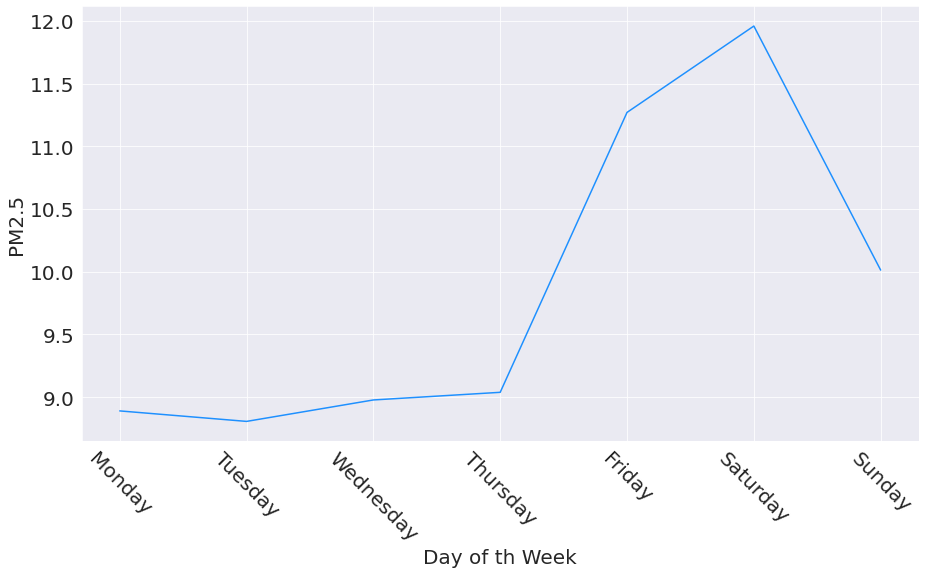

In [186]:
# Plot weekday trend
days_dict = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
            }

df_day = df_trends.groupby("dayname", as_index = False).mean()
df_day = df_day.sort_values(by = ['dayname'], axis = 0, ascending = True)
df_day['dayname2'] = df_day['dayname'].apply(lambda x: days_dict[x])

fig = plt.figure(figsize = (15, 8))
plt.rc('font', size = 20)
plt.plot(df_day['dayname2'],df_day['y'], color = 'dodgerblue')
plt.tick_params(axis='x', labelrotation = -45)
plt.ylabel("PM2.5")
plt.xlabel("Day of the Week")



Text(0.5, 0, 'Month')

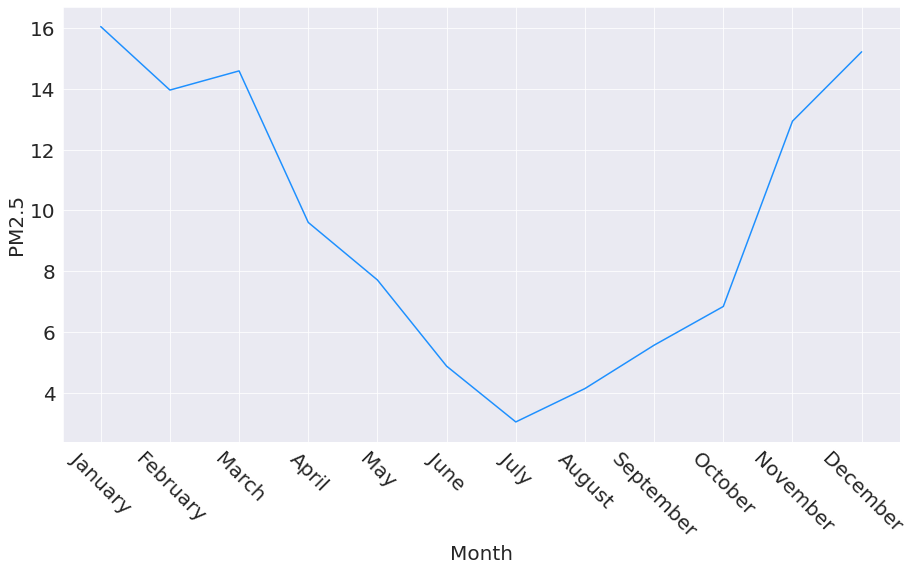

In [188]:
month_dict = {
    1:"January",
    2:"February",
    3:"March",
    4:"April",
    5:"May",
    6:"June",
    7:"July",
    8:"August",
    9:"September",
    10:"October",
    11:"November",
    12:"December"
}

#Plot monthly trend
df_month = df_trends.groupby("month", as_index = False).mean()
df_month = df_month.sort_values(['month'],axis = 0, ascending = True)
df_month['month2'] = df_month['month'].apply(lambda x: month_dict[x])

fig = plt.figure(figsize = (15, 8))
plt.plot(df_month['month2'],df_month['y'], color = 'dodgerblue')
plt.tick_params(axis='x', labelrotation = -45)

plt.ylabel("PM2.5")
plt.xlabel("Month")

### Testing for stationarity and what order to use

In [125]:
## Augmented Dickey Fuller test

from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(all_pm25['y'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.9638835104396666
p-value: 0.038407665699683964


In [220]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(all_pm25.y, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.963884
P-Value                   0.038408
# Lags Used              19.000000
# Observations Used     892.000000
Critical Value (1%)      -3.437702
Critical Value (5%)      -2.864786
Critical Value (10%)     -2.568498
dtype: float64
Is the time series stationary? True


p-values is less than 0.05 so the data is stationary however it could be worth exlporing how using the first order difference affects the results

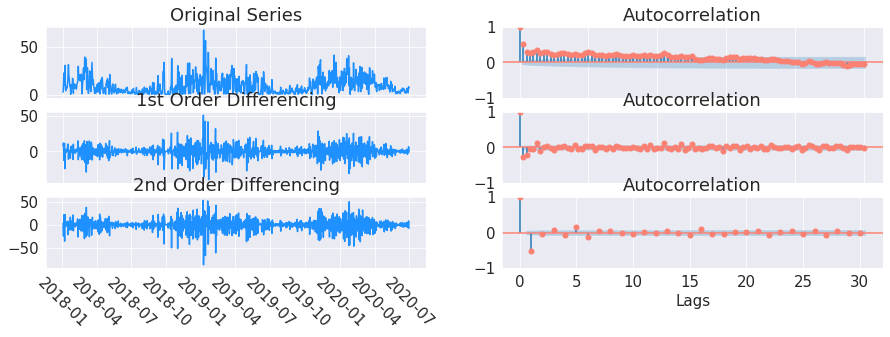

In [191]:
fig = plt.figure(figsize=(15,6))
plt.rc('font', size = 15)

ax1 = plt.subplot(421)
ax1.plot(all_pm25.y, color = 'dodgerblue')
ax1.set_title('Original Series')
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(422)
sm.graphics.tsa.plot_acf(all_pm25.y.dropna(), ax=ax2, lags = 100, color = 'salmon')
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(423)
ax3.plot(all_pm25.y.diff(), color = 'dodgerblue'); 
ax3.set_title('1st Order Differencing')
plt.tick_params('x', labelbottom=False)

ax4 = plt.subplot(424)
sm.graphics.tsa.plot_acf(all_pm25.y.diff().dropna(), ax=ax4, lags = 100, color = 'salmon')
plt.tick_params('x', labelbottom=False)

ax5 = plt.subplot(425)
ax5.plot(all_pm25.y.diff().diff(), color = 'dodgerblue')
ax5.set_title('2nd Order Differencing')
ax5.tick_params(axis='x', labelrotation = -45)

ax6 = plt.subplot(426)
sm.graphics.tsa.plot_acf(all_pm25.y.diff().diff().dropna(), ax=ax6, color = 'salmon')
ax6.set_xlabel("Lags")

plt.show()
fig.savefig("autocorrelations.svg", dpi = 500)

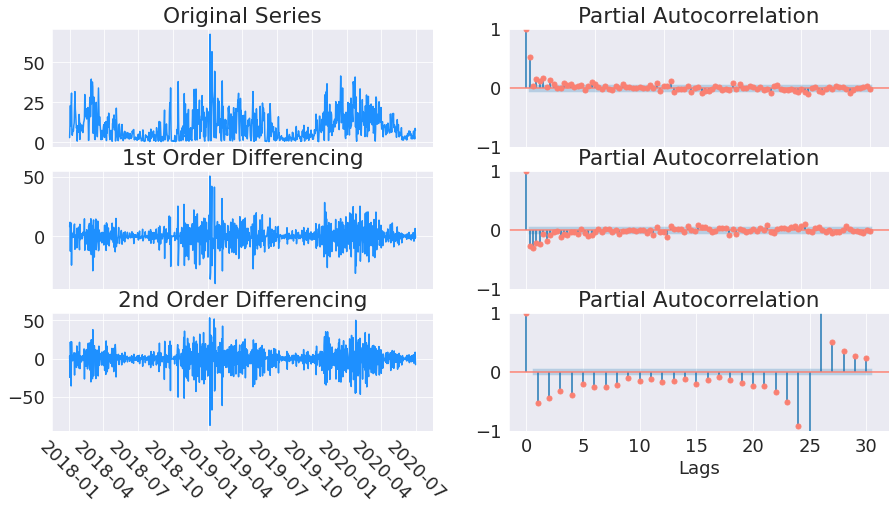

In [195]:
fig = plt.figure(figsize=(15,10))
plt.rc('font', size = 18)

ax1 = plt.subplot(421)
ax1.plot(all_pm25.y, color = 'dodgerblue')
ax1.set_title('Original Series')
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(422)
sm.graphics.tsa.plot_pacf(all_pm25.y.dropna(), ax=ax2, lags = 100, color = 'salmon')
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(423)
ax3.plot(all_pm25.y.diff(), color = 'dodgerblue'); 
ax3.set_title('1st Order Differencing')
plt.tick_params('x', labelbottom=False)

ax4 = plt.subplot(424)
sm.graphics.tsa.plot_pacf(all_pm25.y.diff().dropna(), ax=ax4, lags = 100, color = 'salmon')
plt.tick_params('x', labelbottom=False)

ax5 = plt.subplot(425)
ax5.plot(all_pm25.y.diff().diff(), color = 'dodgerblue')
ax5.set_title('2nd Order Differencing')
ax5.tick_params(axis='x', labelrotation = -45)

ax6 = plt.subplot(426)
sm.graphics.tsa.plot_pacf(all_pm25.y.diff().diff().dropna(), ax=ax6, color = 'salmon')
ax6.set_xlabel("Lags")

plt.show()
fig.savefig("partialautocorrelations.svg", dpi = 500)

### Seasonal decomposition graphs

In [128]:
## Period for seasonal decomposition
period = 30

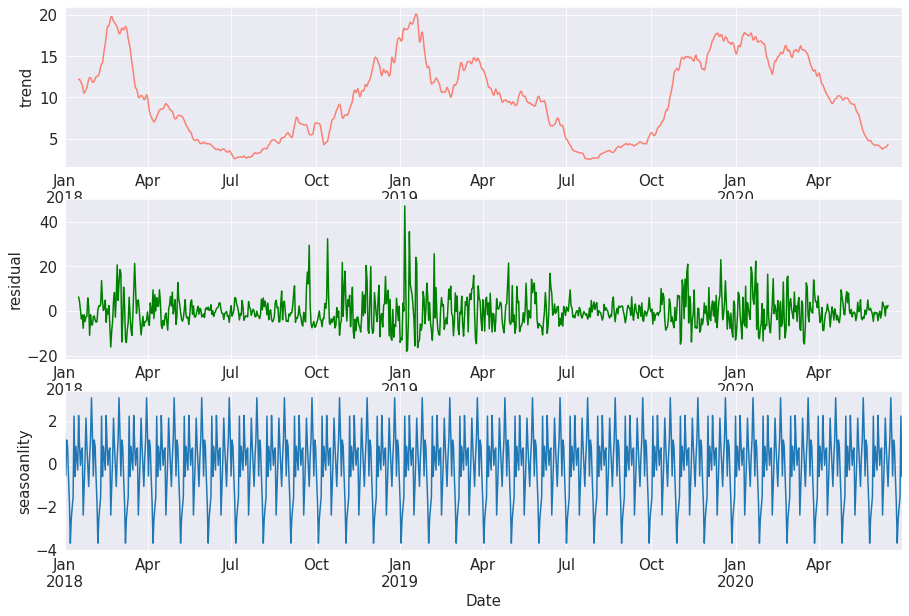

In [201]:
## Seasonal decomposition plot for pm25

from statsmodels.tsa.seasonal import seasonal_decompose

plt.rc('font', size = 15)

df_trends = df_trends[['y']]
res_pm25 = seasonal_decompose(df_trends, model = "additive", period = period)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10))
res_pm25.trend.plot(ax=ax1,ylabel = "trend", xlabel = "Date",color = 'salmon')
plt.xlabel("Date")
res_pm25.resid.plot(ax=ax2,ylabel = "residual", xlabel = "Date", color = 'green')
plt.xlabel("Date")
res_pm25.seasonal.plot(ax=ax3,ylabel = "seasoanlity", xlabel = "Date")
plt.xlabel("Date")
plt.show()

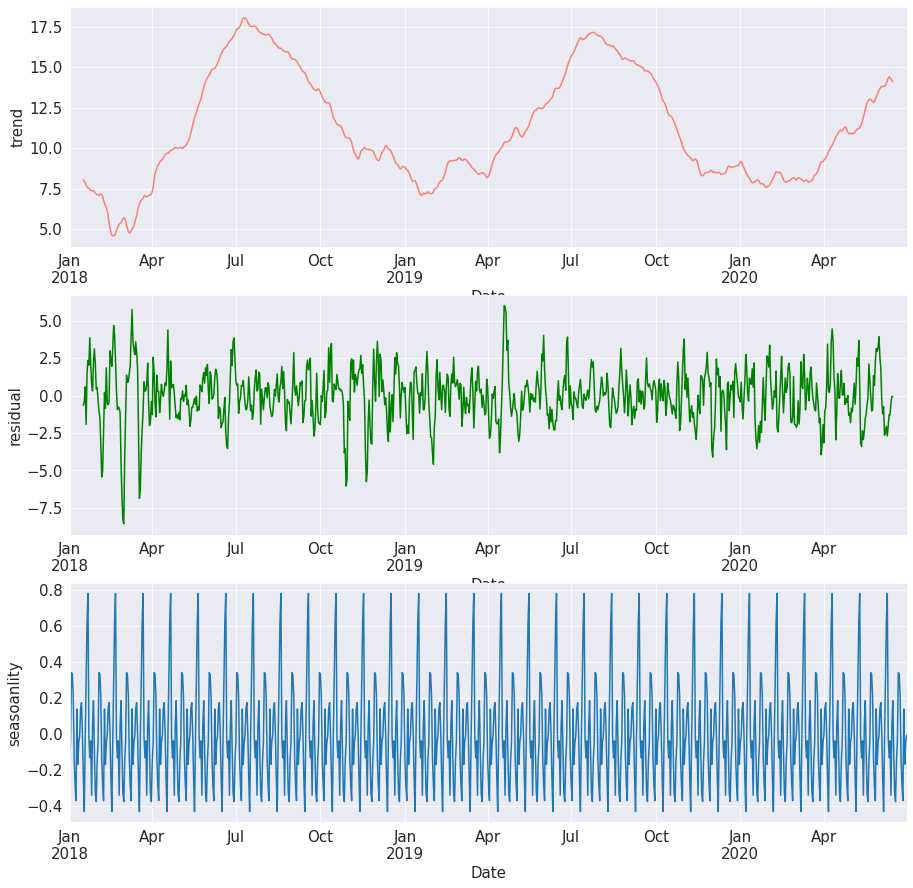

In [200]:
## Seasonal decomposition plot for air temperature

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc('font', size = 15)
res_air_temp = seasonal_decompose(all_pm25.air_temperature, model = "additive", period = period)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,15))
res_air_temp.trend.plot(ax=ax1,ylabel = "trend", xlabel = "Date",color = 'salmon')
res_air_temp.resid.plot(ax=ax2,ylabel = "residual", xlabel = "Date", color = 'green')
res_air_temp.seasonal.plot(ax=ax3,xlabel = "Date", ylabel = "seasoanlity")
plt.show()

### Comparing air temp and PM_25

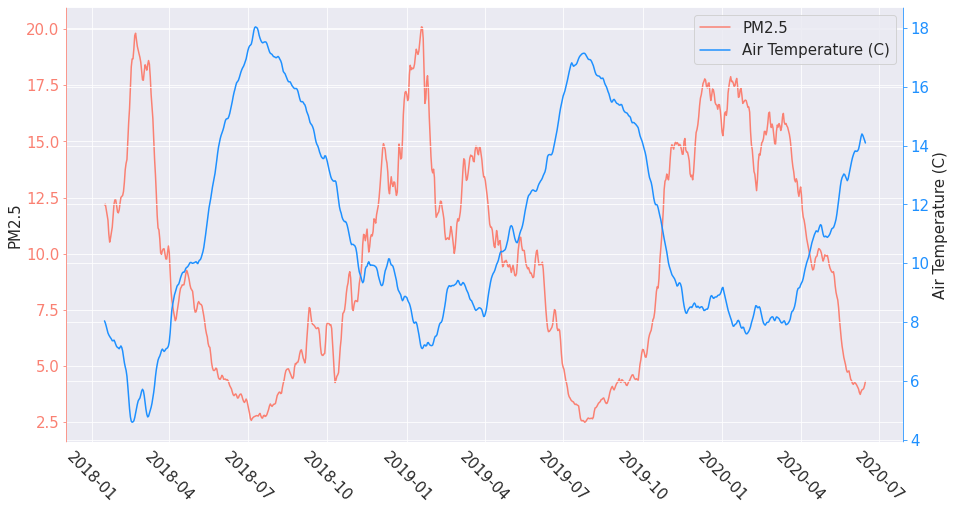

In [173]:
fig, ax = plt.subplots(figsize = (15, 8))

line1, = ax.plot(res_pm25.trend,label = "PM2.5", color = 'salmon')
ax.set_ylabel("PM2.5")
ax.tick_params(axis='y', colors='salmon')

ax2 = ax.twinx()

line2, = ax2.plot(res_air_temp.trend, label = "Air Temperature (C)", color = 'dodgerblue')
ax2.set_ylabel("Air Temperature (C)")
ax2.tick_params(axis='y', colors='dodgerblue')
ax2.spines['right'].set_color('dodgerblue')
ax2.spines['left'].set_color('salmon')

plt.legend(handles = [line1, line2])
plt.rc('font', size = 20)
ax.tick_params(axis='x', labelrotation = -45)

plt.show()

## Model Selection

In [132]:

#ARIMA model:(p,d,q)
#SARIMA model:(p,d,q)(P,D,Q,m)
#ARIMAX model:(p,d,q) + exog
#SARIMAX model:(p,d,q)(P,D,Q,m) +exog

#ARIMA(p,d,q)
#p is the number of autoregressive terms,
#d is the number of nonseasonal differences needed for stationarity, and
#q is the number of lagged forecast errors in the prediction equation.

#P: Seasonal autoregressive order.
#D: Seasonal difference order.
#Q: Seasonal moving average order.
#m: The number of time steps for a single seasonal period.

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(actual - forecast)/np.abs(forecast))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = ""#acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

def plot_forecast(model = None, forecast_steps = 30, exog = False, exog_values = None):
    # Build Model

    # Forecast
    if exog:
        fc = model.get_forecast(forecast_steps, alpha=0.05, exog = exog_values[:forecast_steps])
    else:
        fc = model.get_forecast(forecast_steps, alpha=0.05)  # 95% conf
    conf = fc.conf_int()

    # Make as pandas series
    fc_series = pd.Series(fc.predicted_mean, index=test.index)
    lower_series = pd.Series(conf['lower y'], index=test.index)
    upper_series = pd.Series(conf['upper y'], index=test.index) 
    # Plot
    plt.figure(figsize=(18,5), dpi=100)
    plt.plot(all_pm25.y[-60:-(30-forecast_steps)], label='training')
    #plt.plot(test.y[:forecast_steps], label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    print(forecast_accuracy(fc_series.dropna().values, test.y[:forecast_steps]))

def forecast_results(model = None, steps = 214, exog = False, exog_values = None, days_before = 60):
    
    if exog:
        pred = model.get_forecast(steps=steps, exog=exog_values[:steps])
    else:
        pred = model.get_forecast(steps=steps)
    
    pred_ci = pred.conf_int()

    ax = train.y[-days_before:].plot(label='observed', figsize=(20, 15))
    pred.predicted_mean.plot(ax=ax, label='forecast')
    test.y[:steps].plot(ax=ax, label = 'test')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_title('PM2.5 Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('PM2.5')

    plt.legend()
    plt.show()
    
    mape = np.mean(np.abs(test.y[:steps] - pred.predicted_mean)/np.abs(pred.predicted_mean))
    rmse = np.mean((pred.predicted_mean - test.y[:steps])**2)**.5 
    
    print(f"MAPE: {mape}\n RMSE: {rmse}")

## Basic Auto Rgressive (AR) model

In [133]:
model_AR0 = ARIMA(train.y, order = (2, 0,0))
model_AR0_fitted = model_AR0.fit()
model_AR0_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2511.393
Date:                Sun, 15 May 2022   AIC                           5030.786
Time:                        18:14:57   BIC                           5049.159
Sample:                    01-01-2018   HQIC                          5037.874
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4553      0.816     11.594      0.000       7.857      11.054
ar.L1          0.5162      0.033     15.785      0.000       0.452       0.580
ar.L2          0.0159      0.029      0.557      0.578      -0.040       0.072
sigma2        56.9518      1.787     31.870      0.000      53.449      60.454
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1550.55
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             1.56
Prob(H) (two-sided):                  0.21   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

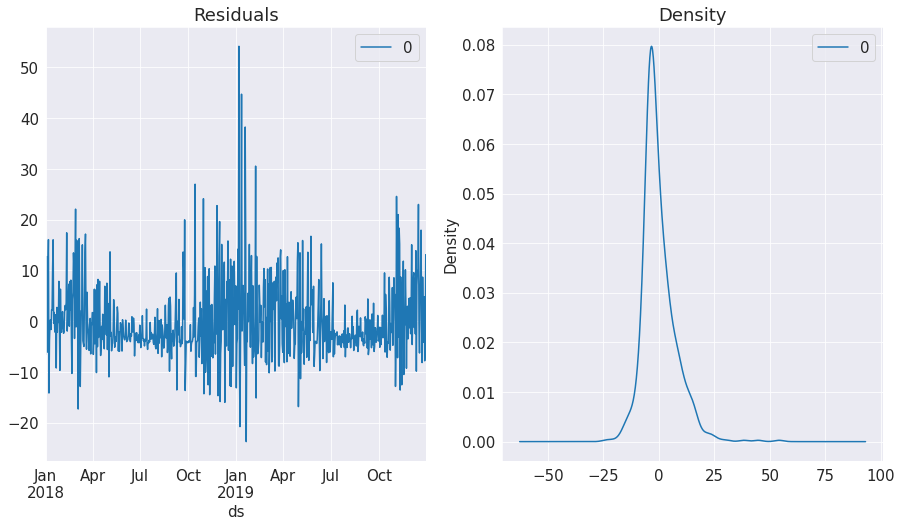

In [134]:
# Plot residual errors
residuals = pd.DataFrame(model_AR0_fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (15, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

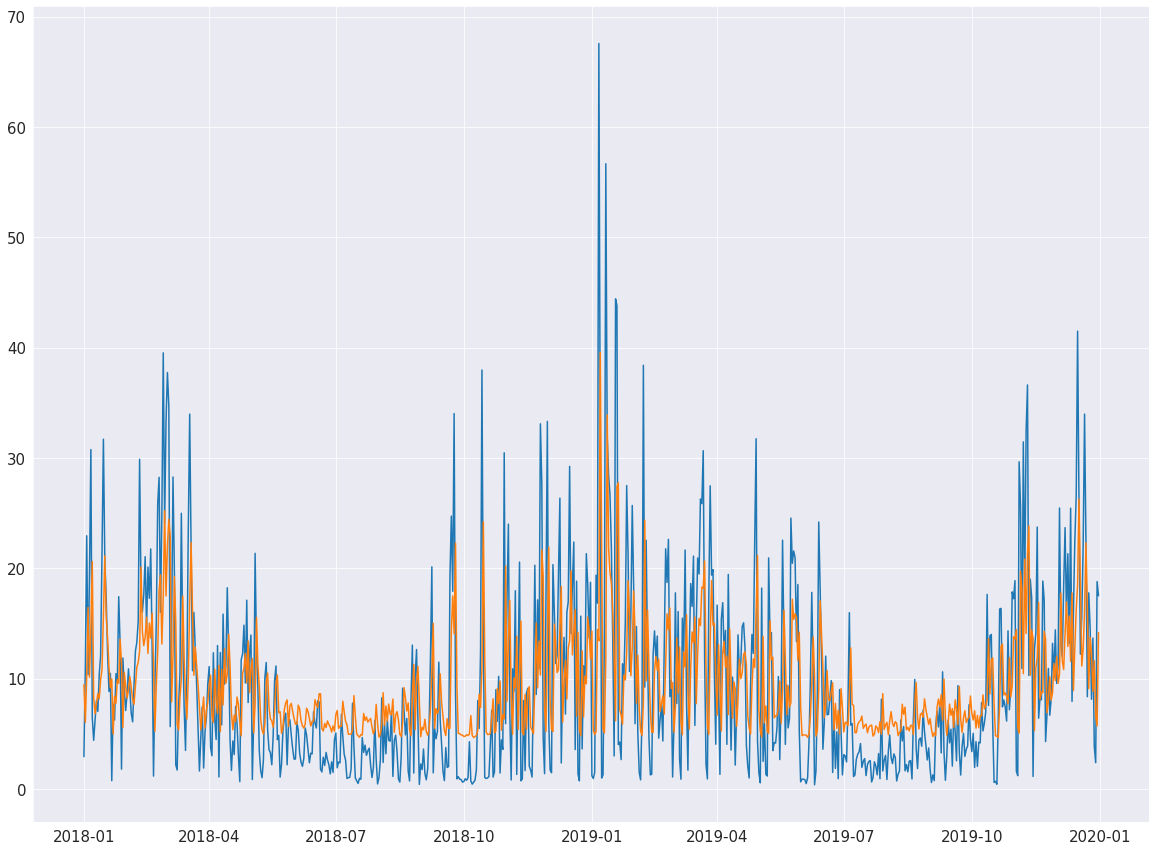

In [135]:
fig = plt.figure(figsize = (20, 15))
plt.plot(train['y'], label = "obs")
plt.plot(model_AR0_fitted.fittedvalues, label = "predicted")

### AR model with first order difference

In [136]:
model_AR1 = ARIMA(train.y, order = (5, 1,0))
model_AR1_fitted = model_AR1.fit()
model_AR1_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2508.817
Date:                Sun, 15 May 2022   AIC                           5029.633
Time:                        18:15:03   BIC                           5057.184
Sample:                    01-01-2018   HQIC                          5040.263
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4538      0.031    -14.643      0.000      -0.514      -0.393
ar.L2         -0.4715      0.027    -17.292      0.000      -0.525      -0.418
ar.L3         -0.3351      0.033    -10.014      0.000      -0.401      -0.270
ar.L4         -0.2898      0.031     -9.474      0.000      -0.350      -0.230
ar.L5         -0.0678      0.029     -2.351      0.019      -0.124      -0.011
sigma2        57.0596      1.542     37.014      0.000      54.038      60.081
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1164.50
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.86
Prob(H) (two-sided):                  0.47   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

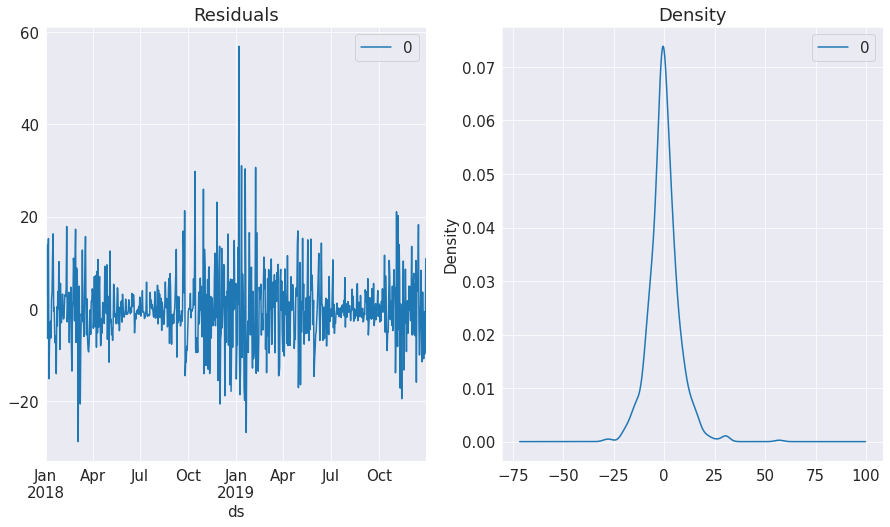

In [137]:
# Plot residual errors
residuals = pd.DataFrame(model_AR1_fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (15, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

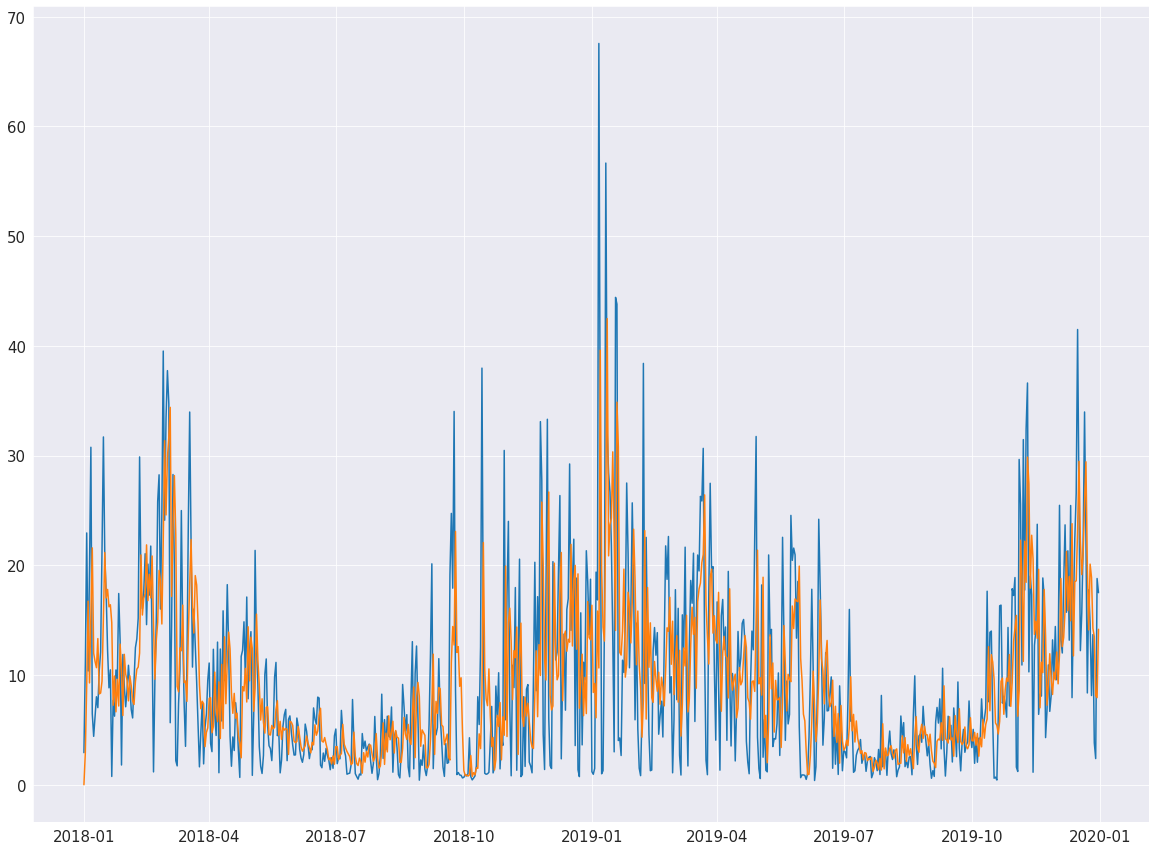

In [138]:
fig = plt.figure(figsize = (20, 15))
plt.plot(train['y'], label = "obs")
plt.plot(model_AR1_fitted.fittedvalues, label = "predicted")

## Basic Moving Average (MA) model

In [139]:
model_MA0 = ARIMA(train.y, order = (0, 0, 15))
model_MA0_fitted = model_MA0.fit()
model_MA0_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                ARIMA(0, 0, 15)   Log Likelihood               -2483.610
Date:                Sun, 15 May 2022   AIC                           5001.221
Time:                        18:15:12   BIC                           5079.303
Sample:                    01-01-2018   HQIC                          5031.345
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4558      1.032      9.161      0.000       7.433      11.479
ma.L1          0.4938      0.035     13.914      0.000       0.424       0.563
ma.L2          0.1633      0.035      4.626      0.000       0.094       0.232
ma.L3          0.1125      0.037      3.030      0.002       0.040       0.185
ma.L4          0.0617      0.040      1.539      0.124      -0.017       0.140
ma.L5          0.2210      0.034      6.573      0.000       0.155       0.287
ma.L6          0.1173      0.042      2.794      0.005       0.035       0.200
ma.L7          0.1231      0.039      3.145      0.002       0.046       0.200
ma.L8          0.1564      0.042      3.768      0.000       0.075       0.238
ma.L9          0.1071      0.042      2.536      0.011       0.024       0.190
ma.L10         0.0493      0.043      1.155      0.248      -0.034       0.133
ma.L11         0.0463      0.043      1.066      0.286      -0.039       0.131
ma.L12         0.0932      0.036      2.584      0.010       0.023       0.164
ma.L13         0.1075      0.040      2.656      0.008       0.028       0.187
ma.L14         0.0596      0.034      1.757      0.079      -0.007       0.126
ma.L15        -0.0228      0.037     -0.619      0.536      -0.095       0.049
sigma2        52.7498      2.036     25.908      0.000      48.759      56.740
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1398.59
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             1.42
Prob(H) (two-sided):                  0.48   Kurtosis:                         9.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

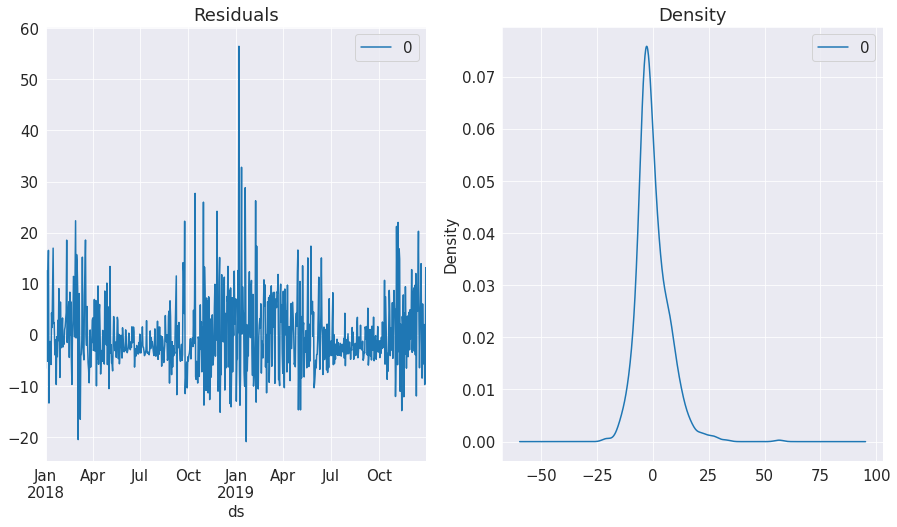

In [140]:
# Plot residual errors
residuals = pd.DataFrame(model_MA0_fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (15, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

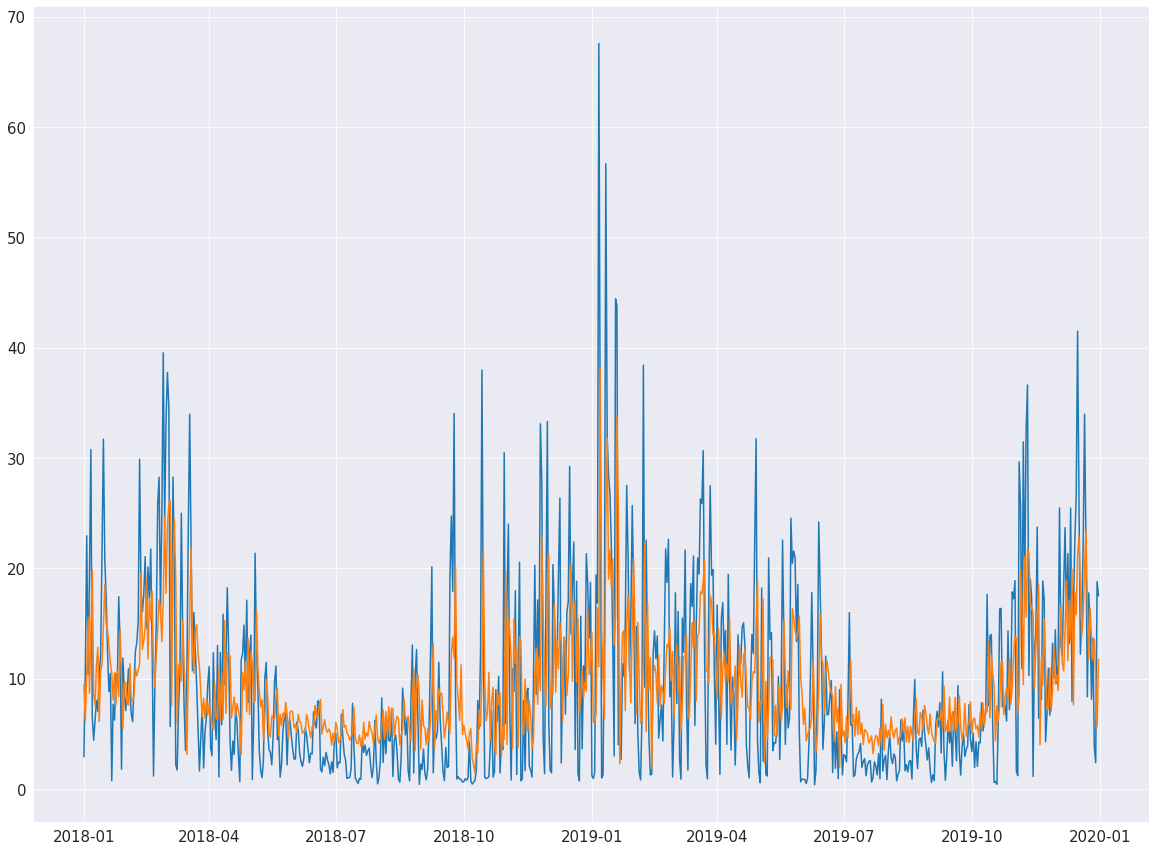

In [141]:
fig = plt.figure(figsize = (20, 15))
plt.plot(train['y'], label = "obs")
plt.plot(model_MA0_fitted.fittedvalues, label = "predicted")

### MA model with first order difference

In [142]:
model_MA1 = ARIMA(train.y, order = (0, 1, 3))
model_MA1_fitted = model_MA1.fit()
model_MA1_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -2482.264
Date:                Sun, 15 May 2022   AIC                           4972.527
Time:                        18:15:19   BIC                           4990.894
Sample:                    01-01-2018   HQIC                          4979.614
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5478      0.032    -16.881      0.000      -0.611      -0.484
ma.L2         -0.3403      0.031    -11.142      0.000      -0.400      -0.280
ma.L3         -0.0169      0.027     -0.620      0.535      -0.070       0.037
sigma2        52.9864      1.340     39.534      0.000      50.359      55.613
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1599.21
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             1.40
Prob(H) (two-sided):                  0.21   Kurtosis:                         9.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

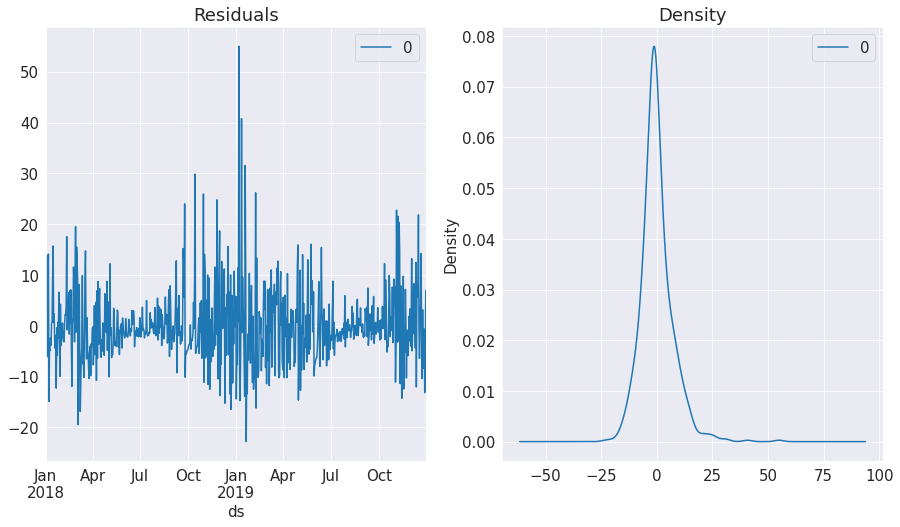

In [143]:
# Plot residual errors
residuals = pd.DataFrame(model_MA1_fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (15, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

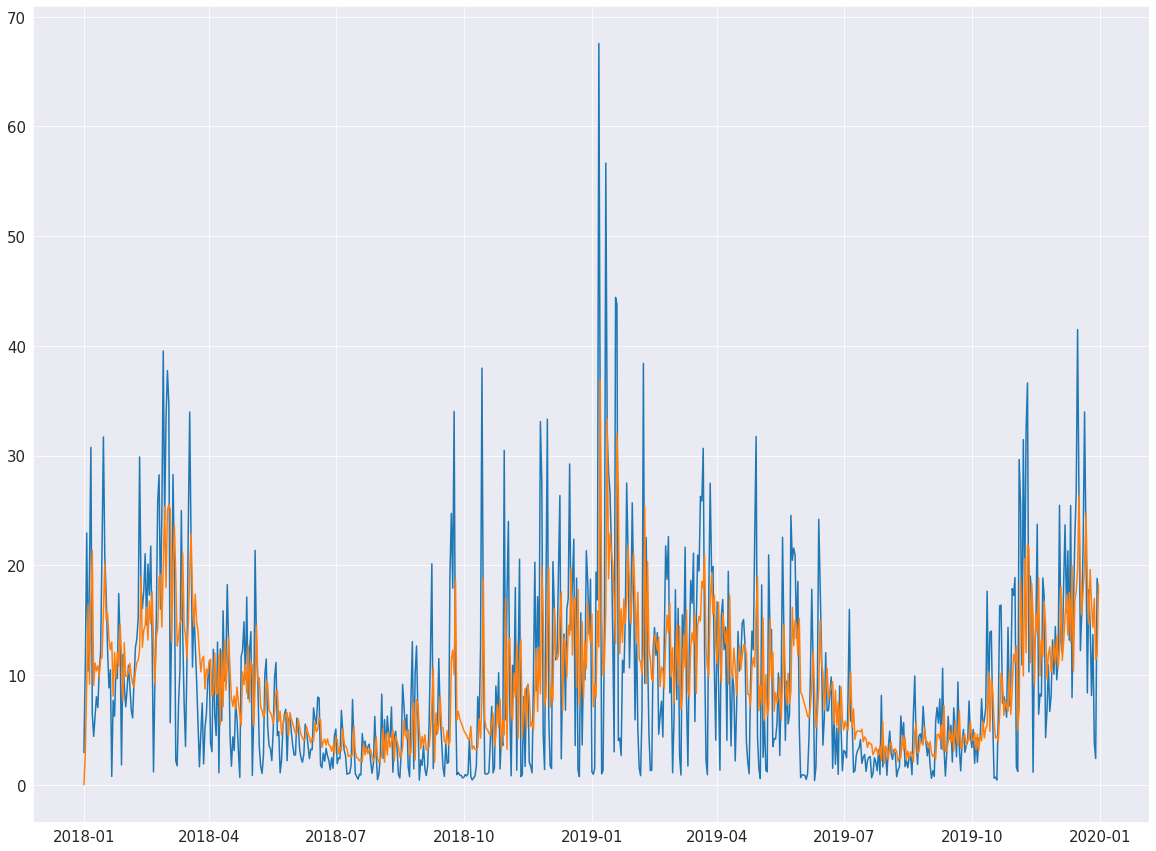

In [144]:
fig = plt.figure(figsize = (20, 15))
plt.plot(train['y'], label = "obs")
plt.plot(model_MA1_fitted.fittedvalues, label = "predicted")

## Basic ARIMA model

In [145]:
model_ARIMA0 = ARIMA(train.y, order = (2, 0, 15))
model_ARIMA0_fitted = model_ARIMA0.fit()
model_ARIMA0_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                ARIMA(2, 0, 15)   Log Likelihood               -2472.579
Date:                Sun, 15 May 2022   AIC                           4983.158
Time:                        18:15:32   BIC                           5070.425
Sample:                    01-01-2018   HQIC                          5016.826
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0423      2.453      4.094      0.000       5.234      14.850
ar.L1          0.3471      0.463      0.749      0.454      -0.561       1.255
ar.L2          0.6275      0.456      1.376      0.169      -0.266       1.521
ma.L1          0.1149      0.463      0.248      0.804      -0.793       1.023
ma.L2         -0.6652      0.247     -2.690      0.007      -1.150      -0.181
ma.L3         -0.2595      0.159     -1.636      0.102      -0.570       0.051
ma.L4         -0.0866      0.046     -1.887      0.059      -0.176       0.003
ma.L5          0.1185      0.038      3.110      0.002       0.044       0.193
ma.L6          0.0005      0.085      0.006      0.995      -0.166       0.167
ma.L7         -0.0371      0.058     -0.639      0.523      -0.151       0.077
ma.L8          0.0564      0.047      1.193      0.233      -0.036       0.149
ma.L9         -0.0170      0.047     -0.361      0.718      -0.109       0.075
ma.L10        -0.0769      0.047     -1.625      0.104      -0.170       0.016
ma.L11        -0.0272      0.050     -0.541      0.589      -0.126       0.071
ma.L12         0.0523      0.035      1.514      0.130      -0.015       0.120
ma.L13         0.0605      0.048      1.270      0.204      -0.033       0.154
ma.L14         0.0085      0.031      0.275      0.783      -0.052       0.069
ma.L15        -0.0464      0.044     -1.055      0.292      -0.132       0.040
sigma2        51.1558      1.752     29.206      0.000      47.723      54.589
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1581.24
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             1.41
Prob(H) (two-sided):                  0.34   Kurtosis:                         9.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

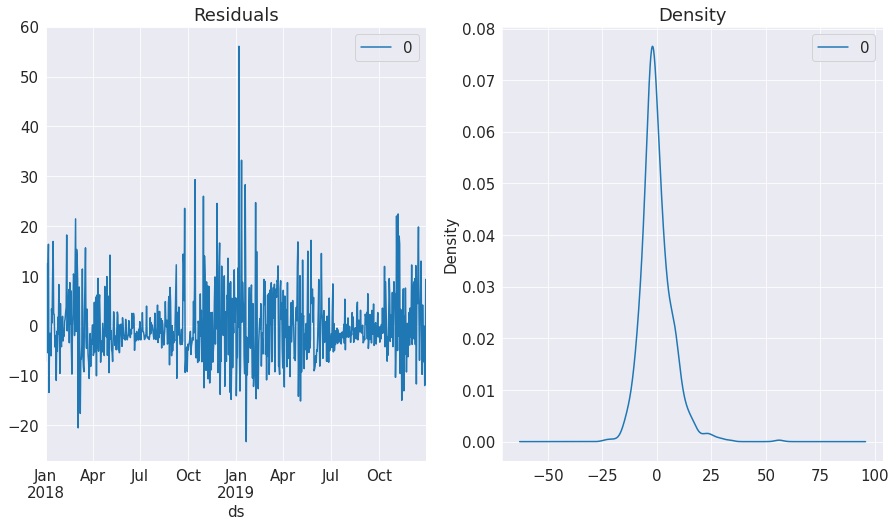

In [146]:
# Plot residual errors
residuals = pd.DataFrame(model_ARIMA0_fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (15, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

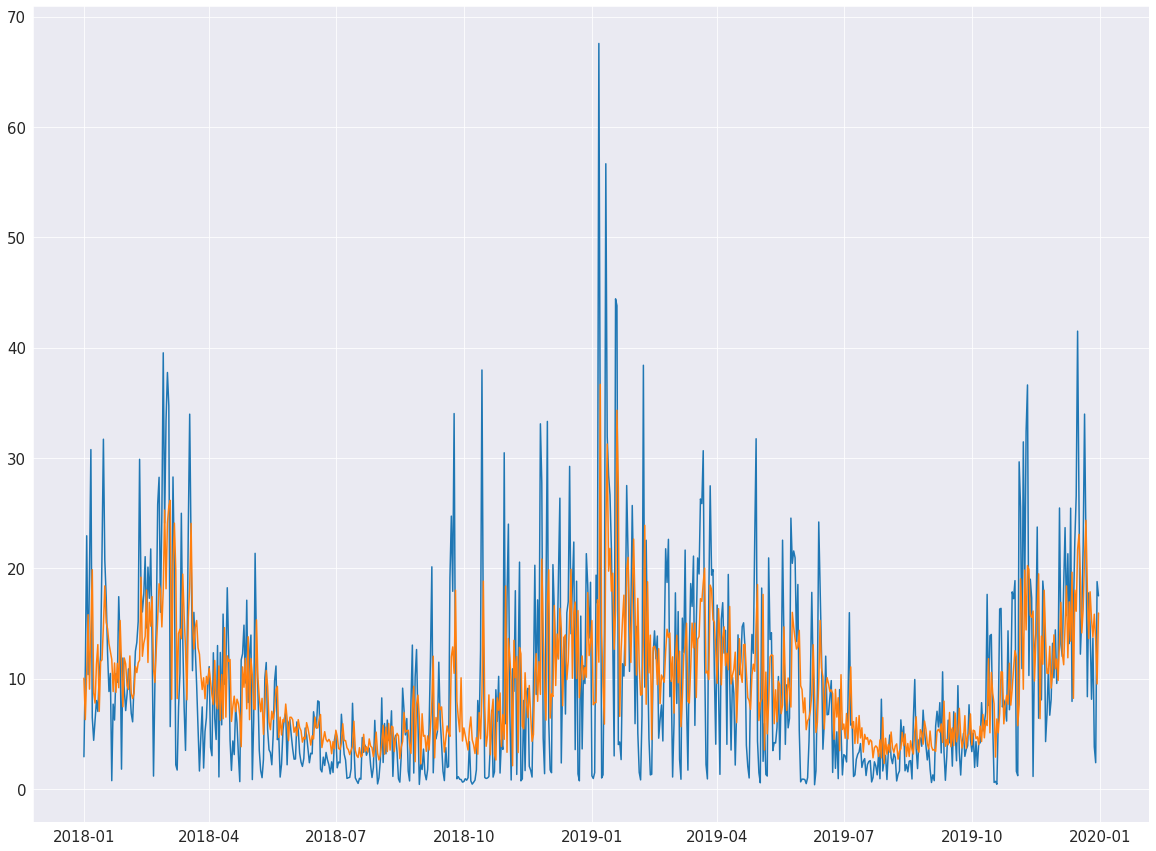

In [147]:
fig = plt.figure(figsize = (20, 15))
plt.plot(train['y'], label = "obs")
plt.plot(model_ARIMA0_fitted.fittedvalues, label = "predicted")

### ARIMA model with first order difference

In [148]:
model_ARIMA1 = ARIMA(train.y, order = (5, 1, 3))
model_ARIMA1_fitted = model_ARIMA1.fit()
model_ARIMA1_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2475.518
Date:                Sun, 15 May 2022   AIC                           4969.035
Time:                        18:15:37   BIC                           5010.360
Sample:                    01-01-2018   HQIC                          4984.980
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4832      0.355     -1.362      0.173      -1.179       0.212
ar.L2         -0.0546      0.196     -0.278      0.781      -0.440       0.330
ar.L3          0.0261      0.085      0.308      0.758      -0.140       0.192
ar.L4         -0.0775      0.059     -1.313      0.189      -0.193       0.038
ar.L5          0.0834      0.045      1.860      0.063      -0.004       0.171
ma.L1         -0.0518      0.362     -0.143      0.886      -0.762       0.658
ma.L2         -0.5448      0.126     -4.341      0.000      -0.791      -0.299
ma.L3         -0.2597      0.291     -0.894      0.372      -0.829       0.310
sigma2        52.0168      1.387     37.504      0.000      49.298      54.735
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1582.41
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             1.34
Prob(H) (two-sided):                  0.33   Kurtosis:                         9.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

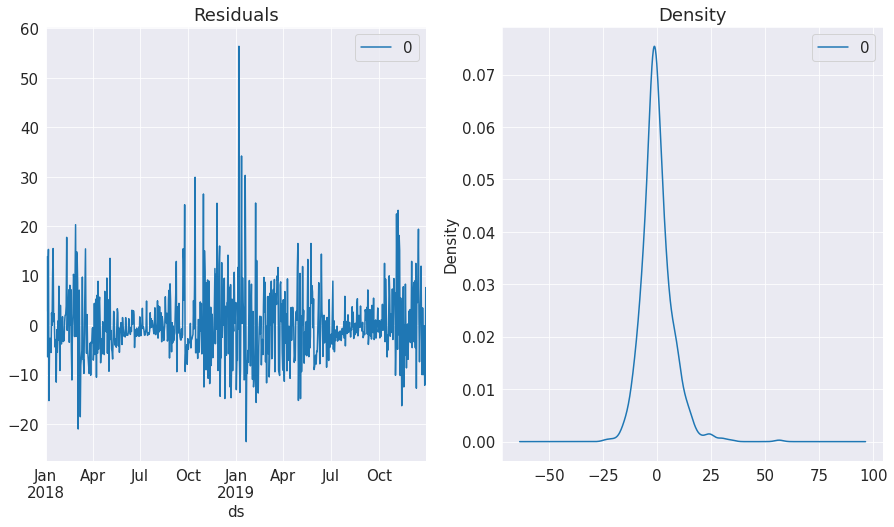

In [149]:
# Plot residual errors
residuals = pd.DataFrame(model_ARIMA1_fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (15, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

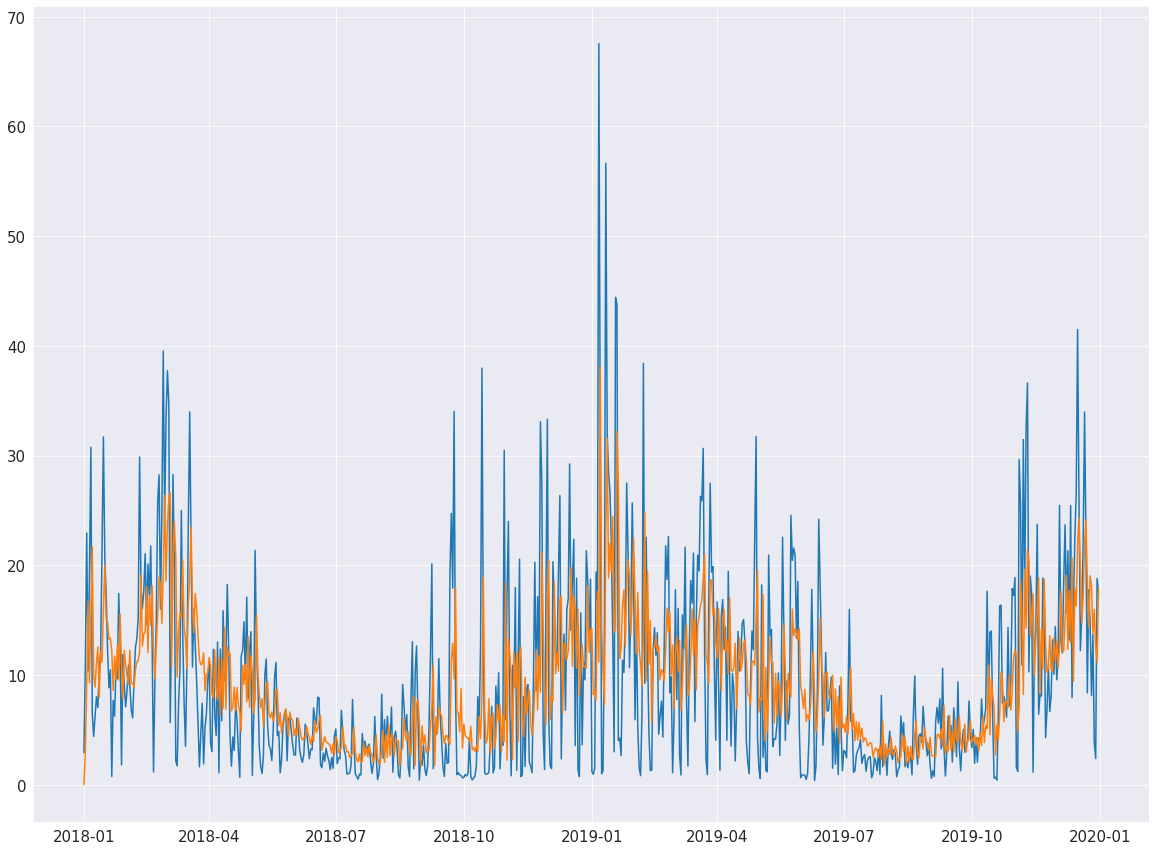

In [150]:
fig = plt.figure(figsize = (20, 15))
plt.plot(train['y'], label = "obs")
plt.plot(model_ARIMA1_fitted.fittedvalues, label = "predicted")

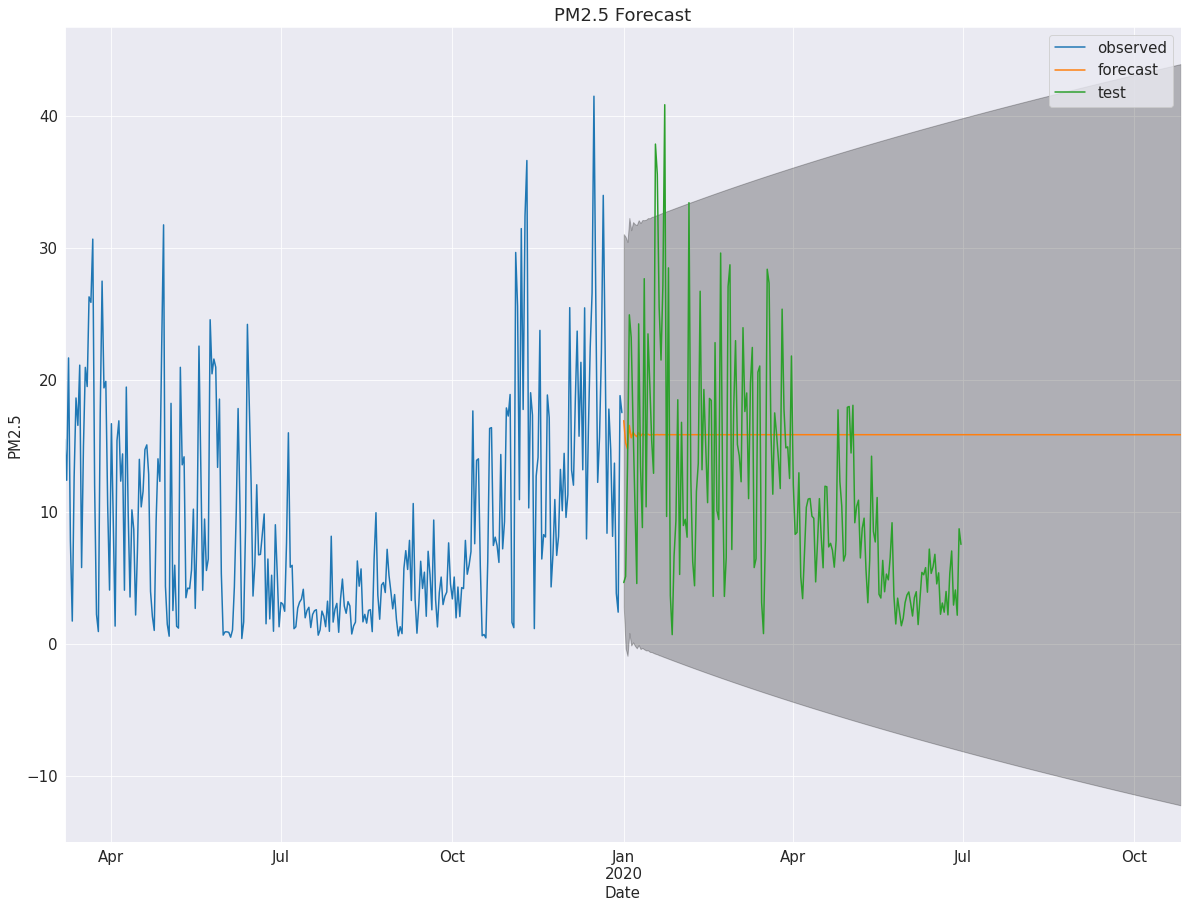

MAPE: 0.5099049267826984
 RMSE: 9.220857950039806


In [208]:
forecast_results(model = model_ARIMA1_fitted,
                 steps = 300,
                 exog = True,
                 exog_values = exog.air_temperature,
                 days_before = 300)

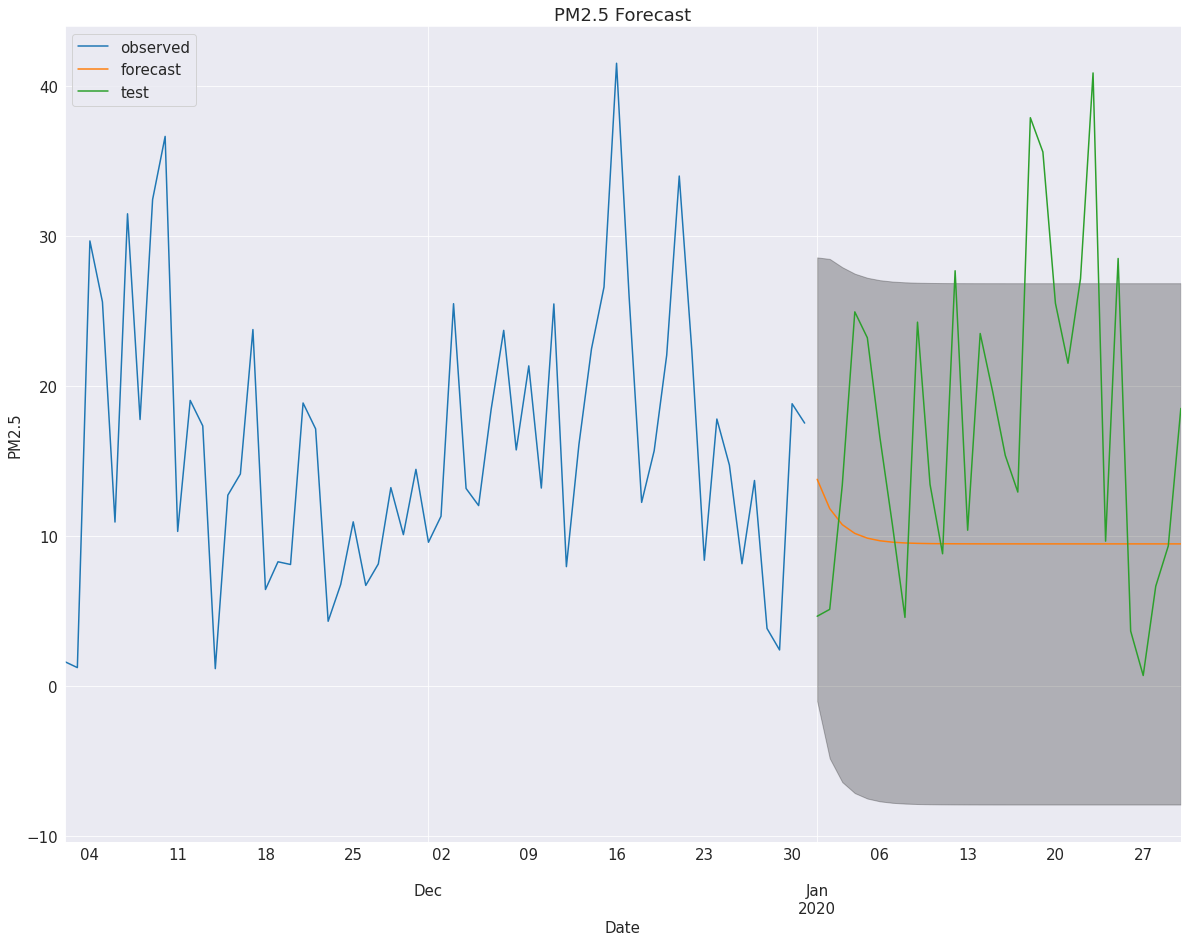

MAPE: 1.0672153269242066
 RMSE: 13.252045805981027


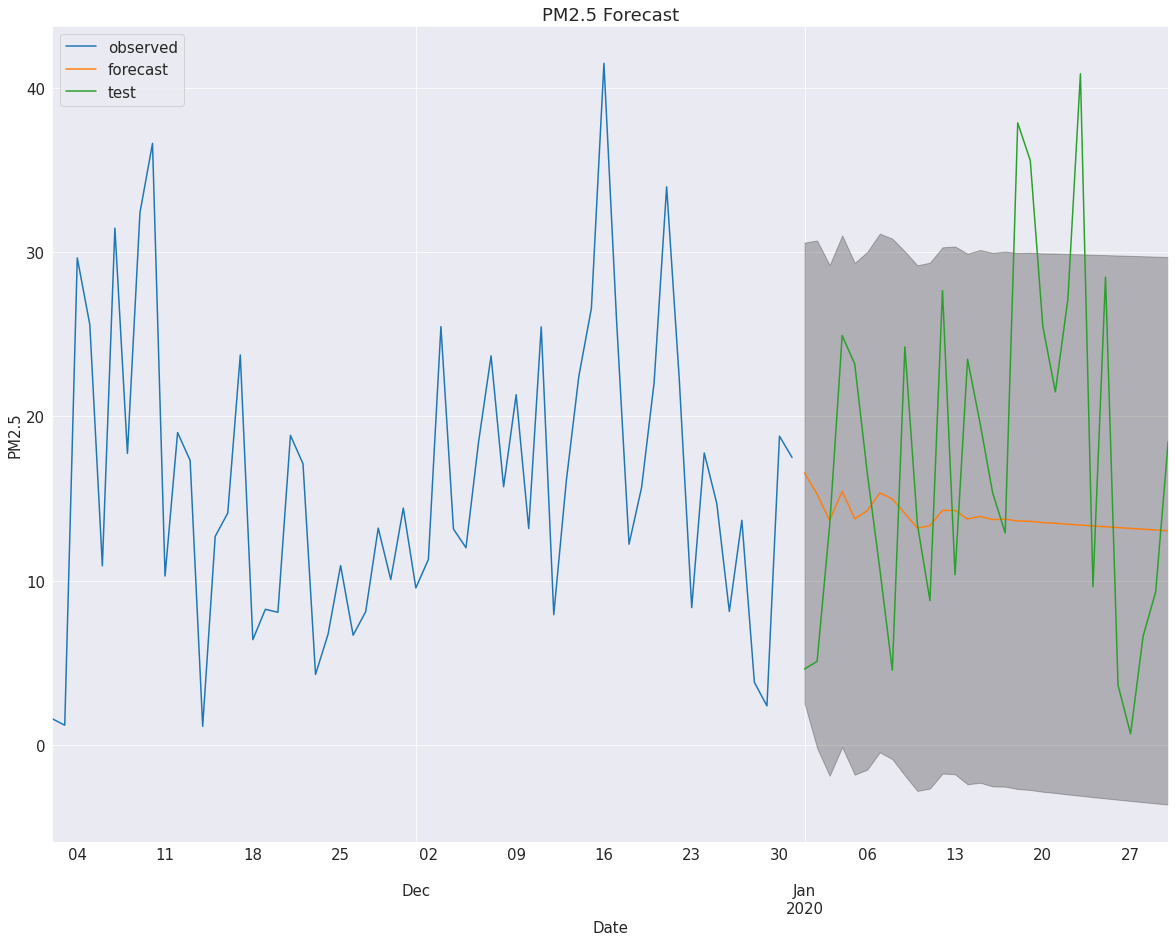

MAPE: 0.6558660918088118
 RMSE: 11.2609153147664


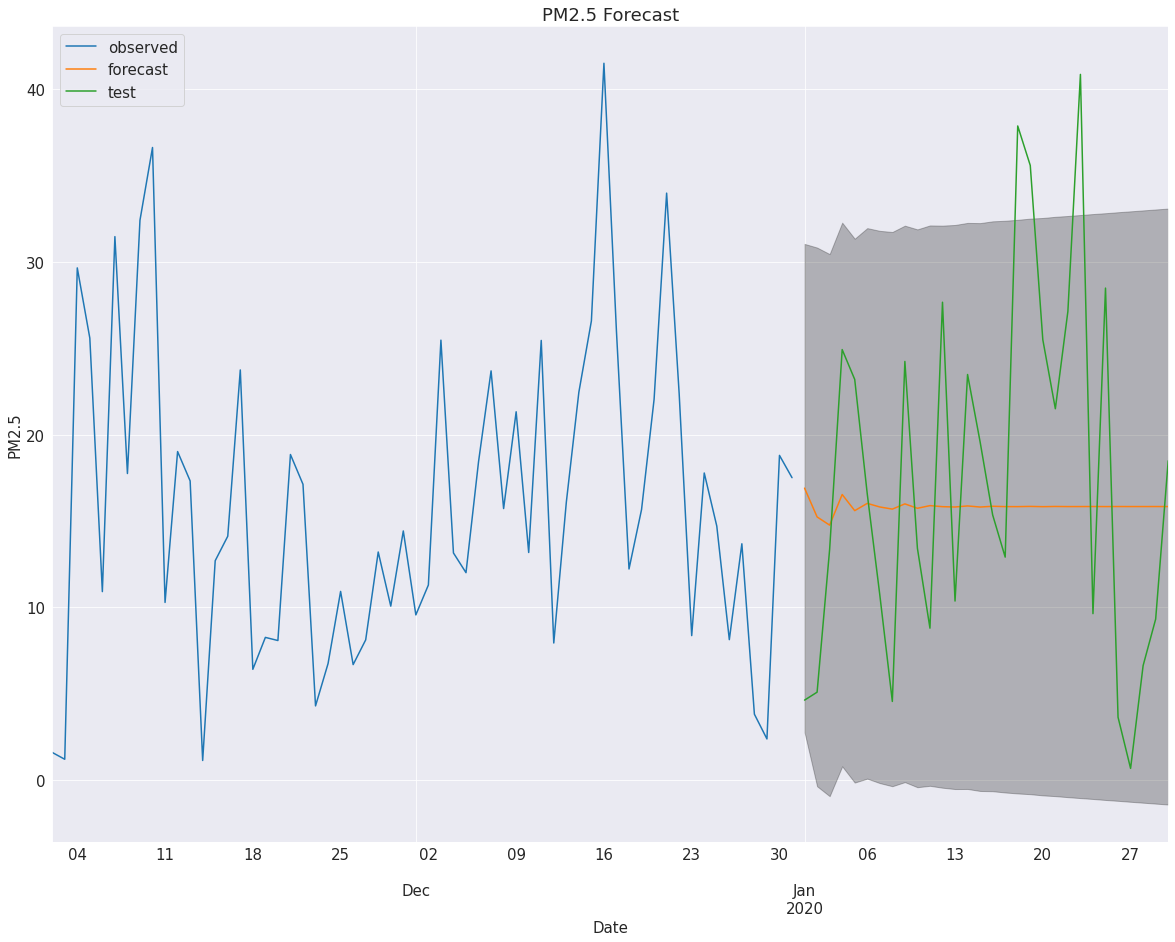

MAPE: 0.5552297526440989
 RMSE: 10.602240999039399


In [215]:

forecast_results(model = model_AR0_fitted, steps = 30, days_before = 60)
forecast_results(model = model_ARIMA0_fitted, steps = 30, days_before = 60)
forecast_results(model = model_ARIMA1_fitted, steps = 30, days_before = 60)



### AR1 model with EXOG values


In [160]:
model_AR1_EXOG_AIR = ARIMA(train.y, 
                       exog = train.air_temperature,
                       order = (5, 1,0)
                      ).fit()
model_AR1_EXOG_AIR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2500.923
Date:                Sun, 15 May 2022   AIC                           5015.846
Time:                        18:18:11   BIC                           5047.988
Sample:                    01-01-2018   HQIC                          5028.247
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
air_temperature    -0.7252      0.154     -4.703      0.000      -1.028      -0.423
ar.L1              -0.4702      0.032    -14.919      0.000      -0.532      -0.408
ar.L2              -0.4792      0.028    -17.417      0.000      -0.533      -0.425
ar.L3              -0.3551      0.033    -10.691      0.000      -0.420      -0.290
ar.L4              -0.3051      0.031     -9.773      0.000      -0.366      -0.244
ar.L5              -0.0866      0.028     -3.122      0.002      -0.141      -0.032
sigma2             55.8150      1.492     37.419      0.000      52.892      58.738
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              1315.31
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.91
Prob(H) (two-sided):                  0.33   Kurtosis:                         9.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

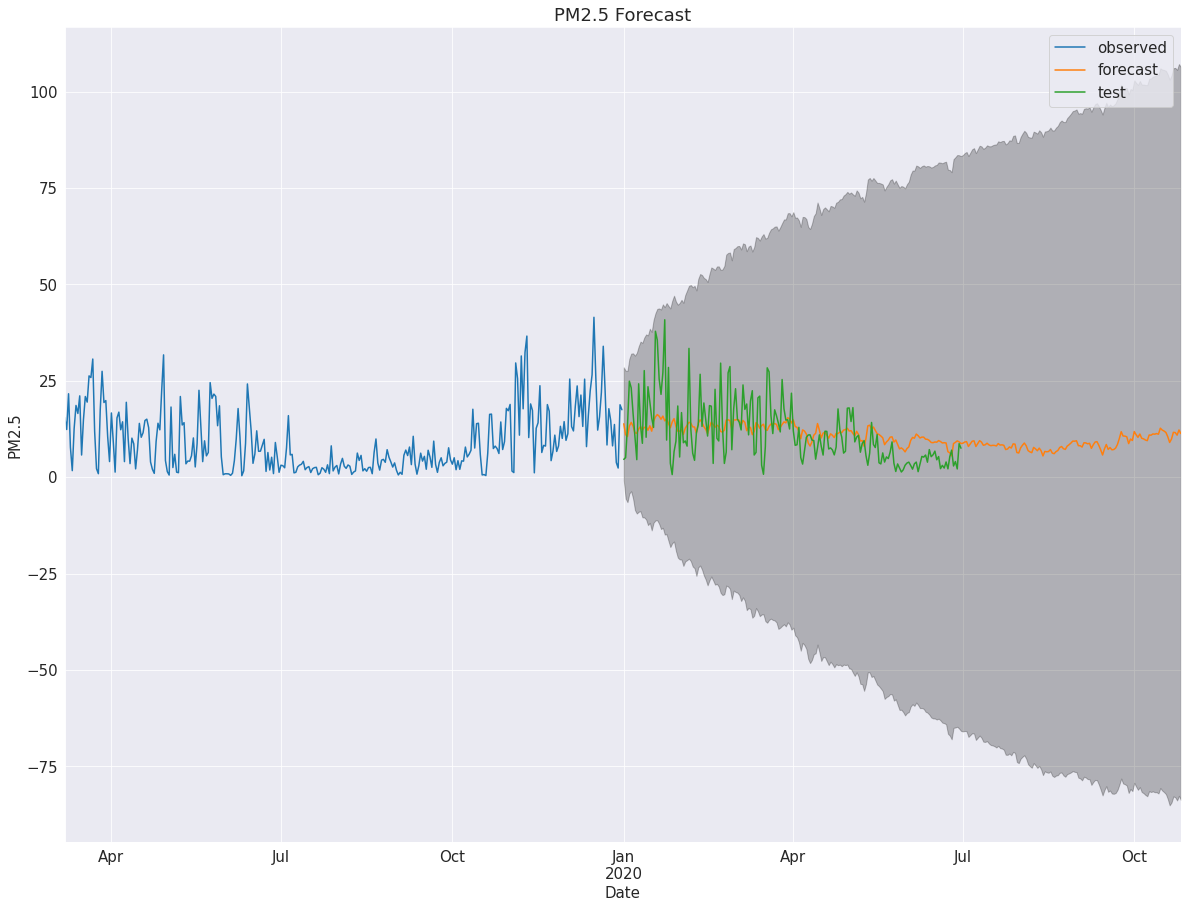

MAPE: 0.4632917130174347
 RMSE: 7.044525789361881


In [161]:
forecast_results(model = model_AR1_EXOG_AIR,
                 steps = 300,
                 exog = True,
                 exog_values = exog.air_temperature,
                 days_before = 300)

## ARIMA1 model with air temp as EXOG

In [162]:
model_ARIMA1_EXOG = ARIMA(train.y, 
                          exog = train.air_temperature, 
                          order = (5, 1, 3)
                         ).fit()
model_ARIMA1_EXOG.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2457.857
Date:                Sun, 15 May 2022   AIC                           4935.713
Time:                        18:18:17   BIC                           4981.630
Sample:                    01-01-2018   HQIC                          4953.430
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
air_temperature    -1.0785      0.120     -9.021      0.000      -1.313      -0.844
ar.L1              -0.4298      0.342     -1.258      0.208      -1.099       0.240
ar.L2               0.0516      0.183      0.282      0.778      -0.307       0.410
ar.L3               0.0025      0.094      0.027      0.979      -0.182       0.187
ar.L4              -0.0554      0.048     -1.159      0.247      -0.149       0.038
ar.L5               0.0910      0.033      2.777      0.005       0.027       0.155
ma.L1              -0.1557      0.349     -0.446      0.655      -0.839       0.528
ma.L2              -0.6514      0.137     -4.764      0.000      -0.919      -0.383
ma.L3              -0.1750      0.304     -0.575      0.565      -0.771       0.421
sigma2             49.4227      1.443     34.252      0.000      46.595      52.251
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1872.90
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             1.44
Prob(H) (two-sided):                  0.18   Kurtosis:                        10.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

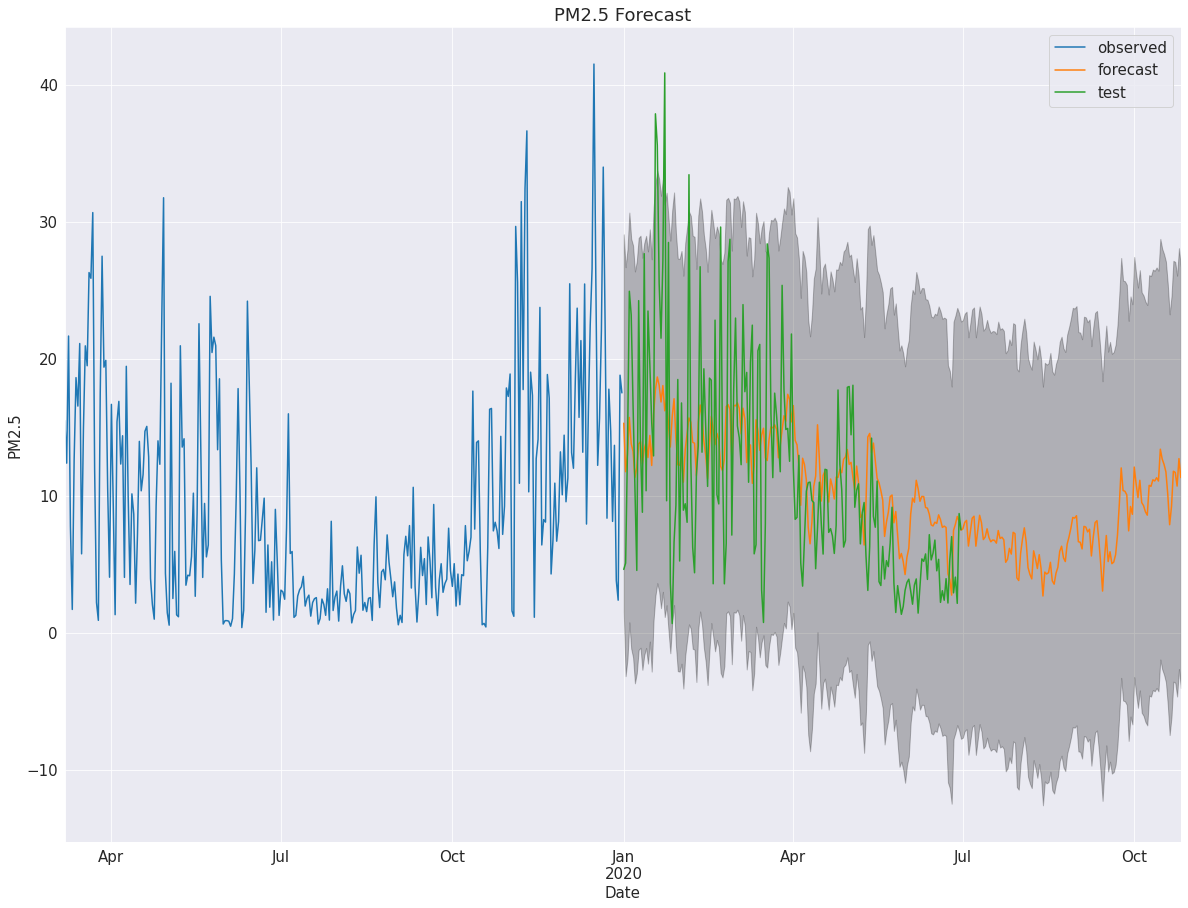

MAPE: 0.43897939558828025
 RMSE: 6.7501653105959845


In [163]:
forecast_results(model = model_ARIMA1_EXOG,
                 steps = 300,
                 exog = True,
                 exog_values = exog.air_temperature,
                 days_before = 300)

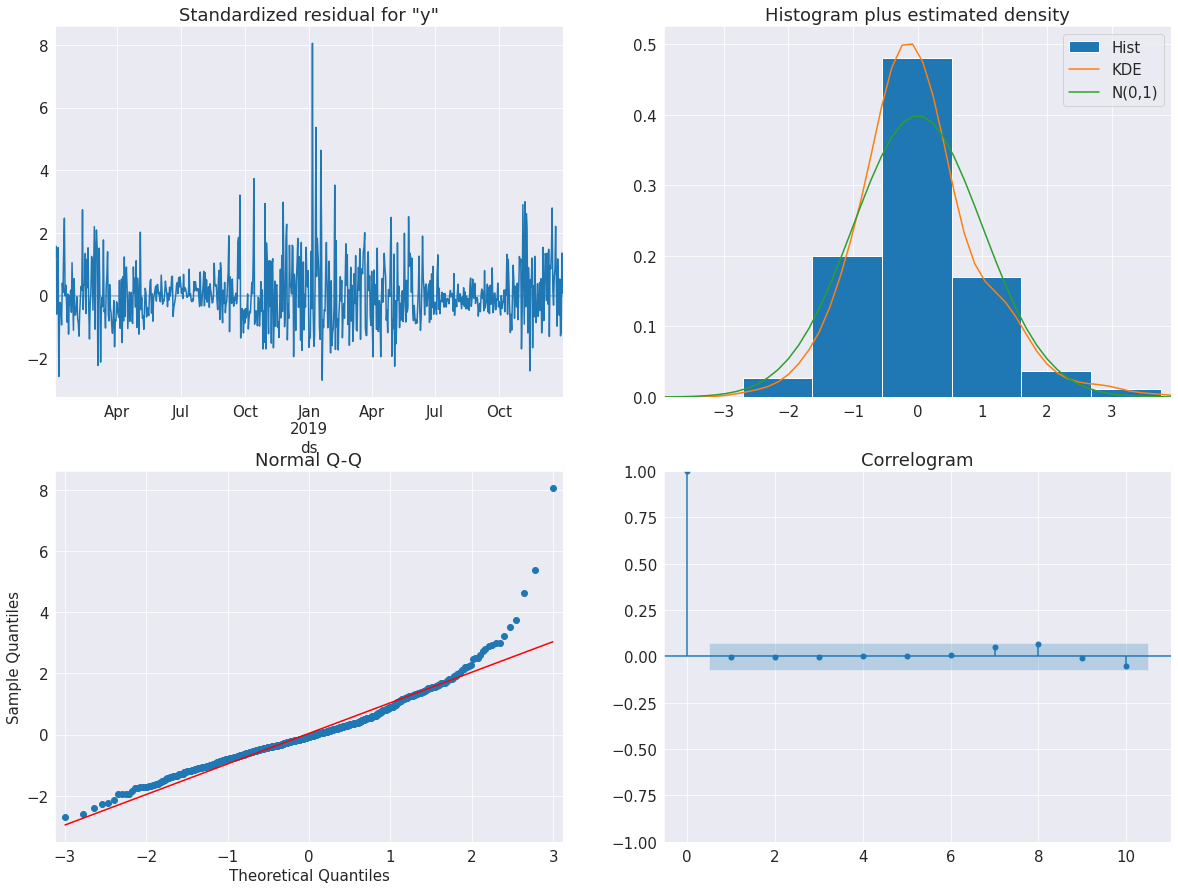

In [206]:
model_ARIMA1_EXOG.plot_diagnostics(figsize=(20,15))
plt.show()

## ARIMA1 model with air temp and wind as EXOG

In [164]:
exog_features = ['wind_speed', 'air_temperature']
model_ARIMA1_EXOG_WIND_AIR = ARIMA(train.y, 
                                   exog = train[exog_features], 
                                   order = (5, 1,3)
                                  ).fit()
model_ARIMA1_EXOG_WIND_AIR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2452.430
Date:                Sun, 15 May 2022   AIC                           4926.861
Time:                        18:19:24   BIC                           4977.369
Sample:                    01-01-2018   HQIC                          4946.349
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
wind_speed         -0.2449      0.071     -3.447      0.001      -0.384      -0.106
air_temperature    -0.9297      0.136     -6.848      0.000      -1.196      -0.664
ar.L1              -0.5117      0.348     -1.472      0.141      -1.193       0.170
ar.L2               0.0082      0.183      0.045      0.964      -0.351       0.367
ar.L3               0.0308      0.096      0.321      0.748      -0.157       0.219
ar.L4              -0.0747      0.051     -1.461      0.144      -0.175       0.026
ar.L5               0.0732      0.040      1.842      0.065      -0.005       0.151
ma.L1              -0.0480      0.354     -0.135      0.892      -0.743       0.647
ma.L2              -0.6323      0.127     -4.979      0.000      -0.881      -0.383
ma.L3              -0.2611      0.300     -0.870      0.385      -0.850       0.327
sigma2             48.7692      1.441     33.845      0.000      45.945      51.593
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1705.13
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             1.37
Prob(H) (two-sided):                  0.17   Kurtosis:                         9.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

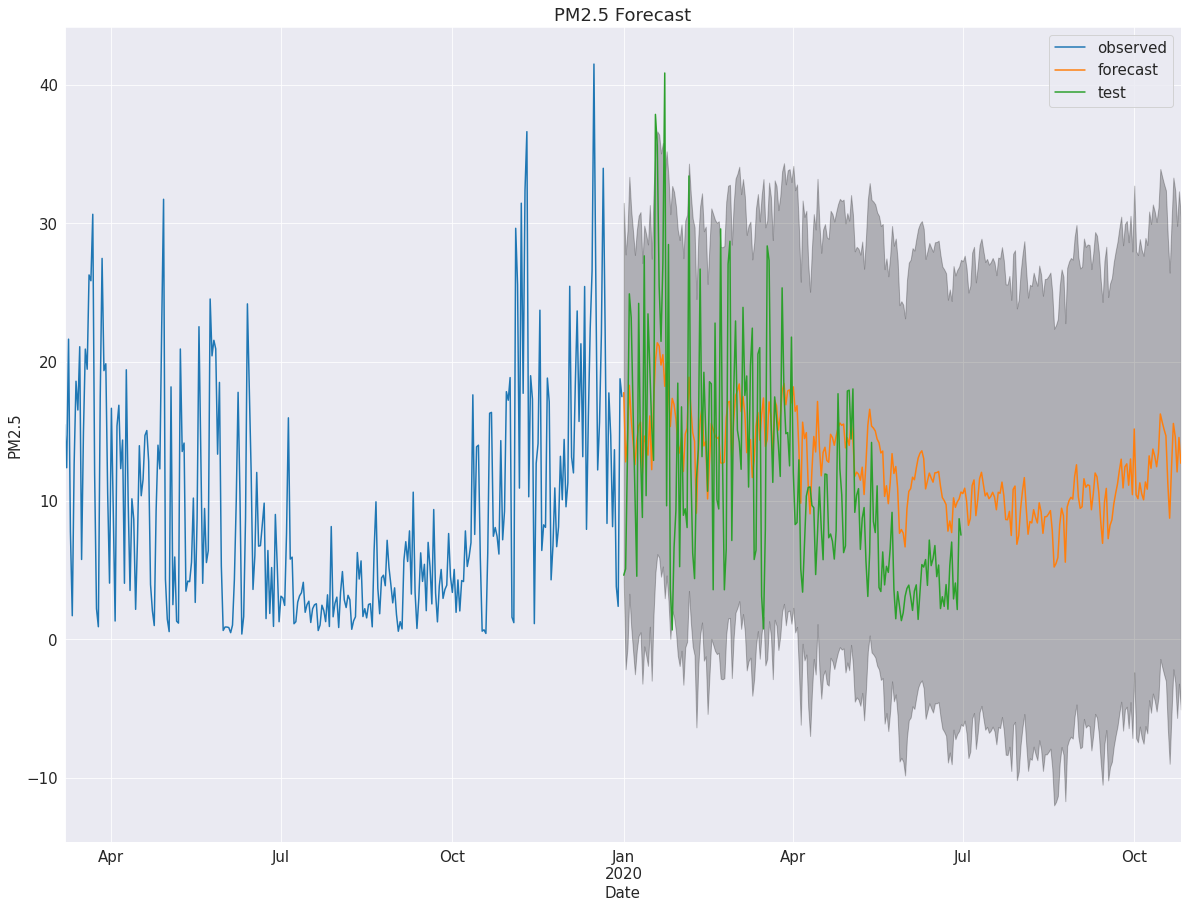

MAPE: 0.44893084000360267
 RMSE: 7.335864236772339


In [172]:
forecast_results(model = model_ARIMA1_EXOG_WIND_AIR,
                 steps = 300,
                 exog = True,
                 exog_values = exog[exog_features],
                 days_before = 300)

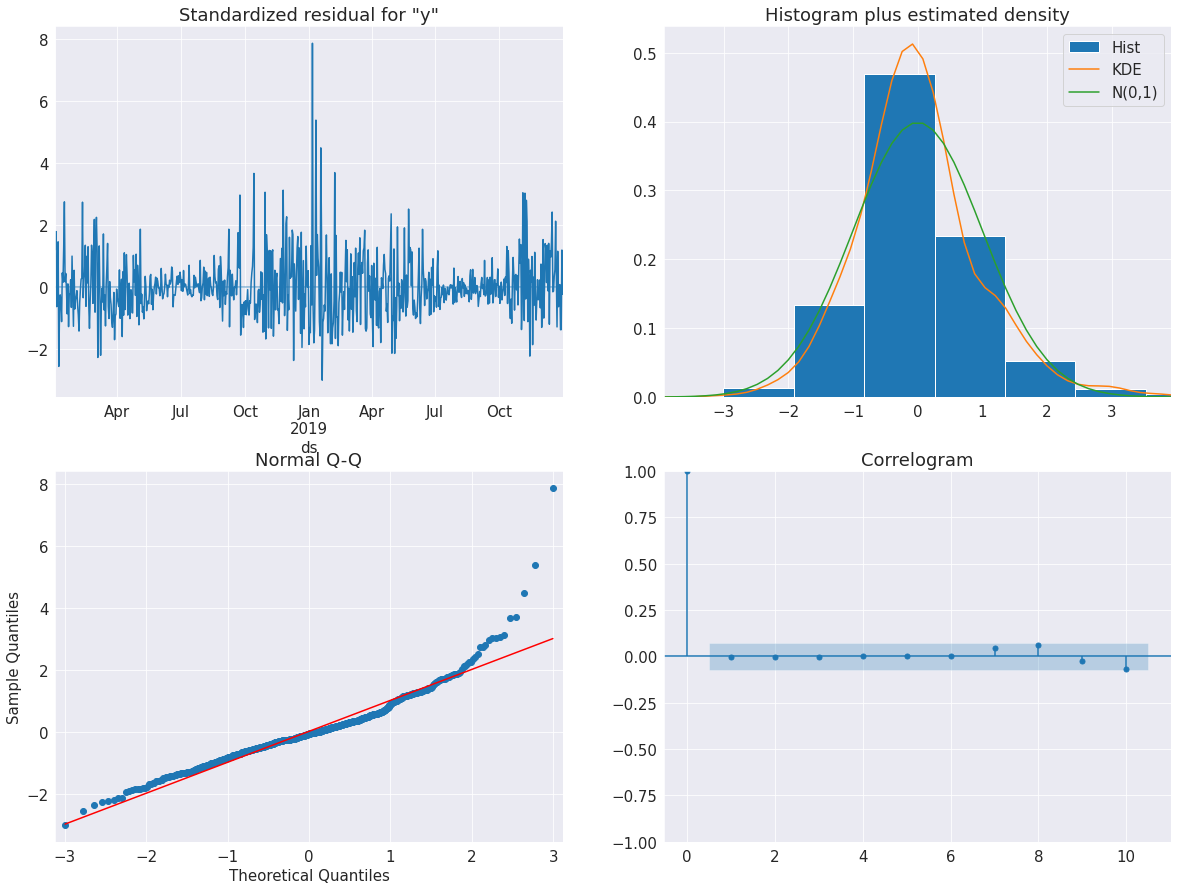

In [205]:
model_ARIMA1_EXOG_WIND_AIR.plot_diagnostics(figsize=(20,15))
plt.show()

### SARIMA model basic

In [167]:
model_SARIMA = sm.tsa.statespace.SARIMAX(train.y,
                                         order=(5,1,3),
                                         trend='c', 
                                         seasonal_order=(5,1,3,12),
                                         enforce_stationarity=False, 
                                         enforce_invertibility=False
                                        ).fit()
model_SARIMA.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15006D+00    |proj g|=  7.68538D-02


 This problem is unconstrained.



At iterate    5    f=  3.13160D+00    |proj g|=  4.80141D-02

At iterate   10    f=  3.07411D+00    |proj g|=  7.07311D-02

At iterate   15    f=  3.05596D+00    |proj g|=  6.10993D-02

At iterate   20    f=  3.04568D+00    |proj g|=  5.63704D-02

At iterate   25    f=  3.04533D+00    |proj g|=  3.23435D-03

At iterate   30    f=  3.04500D+00    |proj g|=  5.21455D-03

At iterate   35    f=  3.04486D+00    |proj g|=  1.26427D-02

At iterate   40    f=  3.04477D+00    |proj g|=  2.83831D-03

At iterate   45    f=  3.04472D+00    |proj g|=  2.41965D-03

At iterate   50    f=  3.04467D+00    |proj g|=  4.54955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  730
Model:             SARIMAX(5, 1, 3)x(5, 1, 3, 12)   Log Likelihood               -2222.609
Date:                            Sun, 15 May 2022   AIC                           4481.218
Time:                                    18:23:48   BIC                           4561.859
Sample:                                01-01-2018   HQIC                          4512.492
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0098      0.007      1.359      0.174      -0.004       0.024
ar.L1         -0.5309      0.259     -2.052      0.040      -1.038      -0.024
ar.L2         -0.2237      0.158     -1.414      0.157      -0.534       0.086
ar.L3          0.0425      0.069      0.619      0.536      -0.092       0.177
ar.L4         -0.1311      0.064     -2.047      0.041      -0.257      -0.006
ar.L5          0.0844      0.054      1.574      0.115      -0.021       0.190
ma.L1         -0.0204      0.264     -0.077      0.938      -0.538       0.497
ma.L2         -0.4051      0.134     -3.027      0.002      -0.667      -0.143
ma.L3         -0.4100      0.206     -1.995      0.046      -0.813      -0.007
ar.S.L12      -0.7083      0.261     -2.713      0.007      -1.220      -0.197
ar.S.L24      -0.2699      0.240     -1.123      0.262      -0.741       0.201
ar.S.L36       0.0112      0.048      0.230      0.818      -0.084       0.106
ar.S.L48      -0.0526      0.043     -1.222      0.222      -0.137       0.032
ar.S.L60    8.124e-05      0.039      0.002      0.998      -0.076       0.076
ma.S.L12      -0.2514      0.438     -0.574      0.566      -1.110       0.608
ma.S.L24      -0.4653      0.289     -1.609      0.108      -1.032       0.102
ma.S.L36      -0.2887      0.259     -1.115      0.265      -0.796       0.219
sigma2        50.6033     17.845      2.836      0.005      15.627      85.580
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1516.73
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             1.34
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

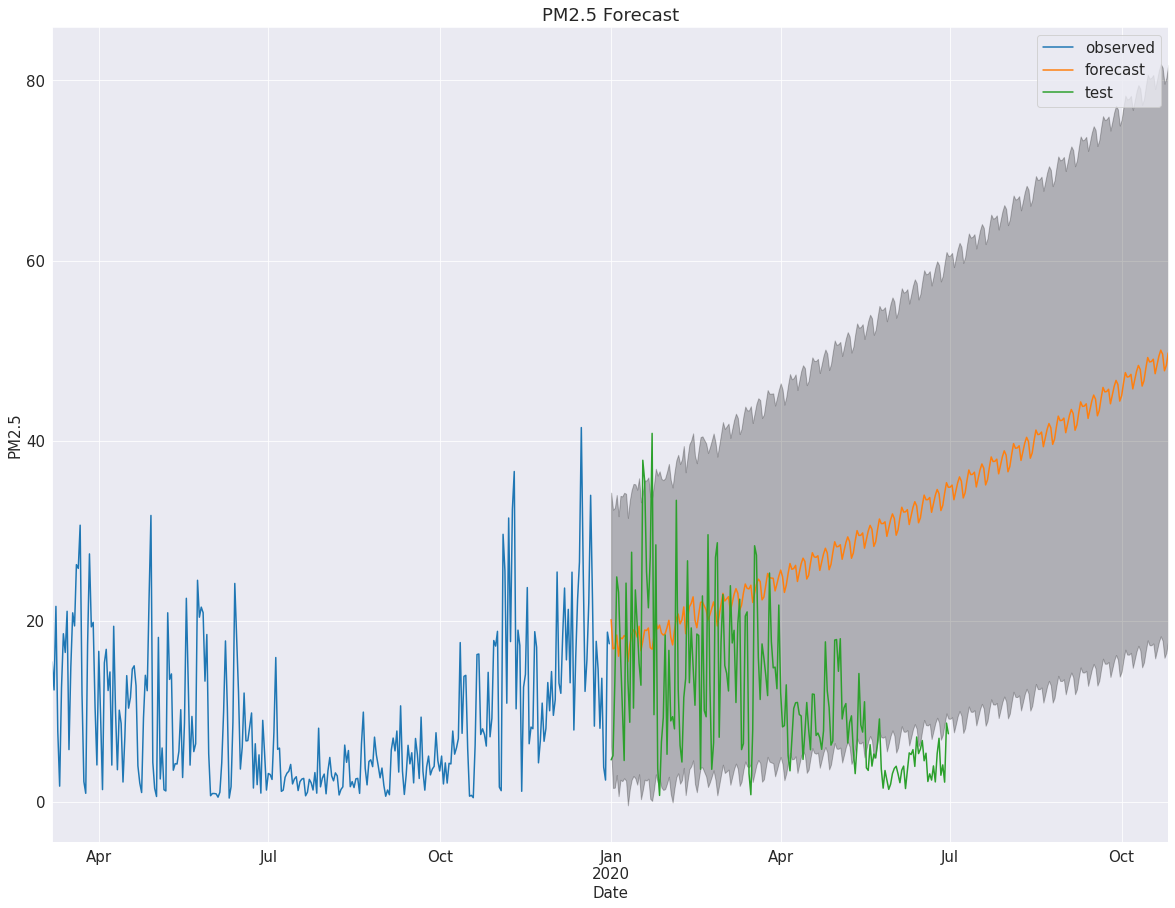

MAPE: 0.5924317784882447
 RMSE: 18.01516180024712


In [170]:
forecast_results(model = model_SARIMA, 
                 steps = 300, 
                 days_before = 300
                )

### SARIMAX model with air temperature

In [97]:
model_SARIMAX = sm.tsa.statespace.SARIMAX(train.y,
                                          order=(5,1,3),
                                          trend='c', 
                                          seasonal_order=(5,1,3,12),
                                          enforce_stationarity=False, 
                                          enforce_invertibility=False, 
                                          exog=train.air_temperature
                                         ).fit()
model_SARIMAX.summary()



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13863D+00    |proj g|=  6.40235D-02

At iterate    5    f=  3.11596D+00    |proj g|=  8.16610D-02

At iterate   10    f=  3.08106D+00    |proj g|=  1.29358D-01

At iterate   15    f=  3.06467D+00    |proj g|=  2.05449D-01

At iterate   20    f=  3.05602D+00    |proj g|=  1.59966D-01

At iterate   25    f=  3.04941D+00    |proj g|=  8.36363D-02

At iterate   30    f=  3.04557D+00    |proj g|=  7.11514D-01

At iterate   35    f=  3.03805D+00    |proj g|=  1.81831D-01

At iterate   40    f=  3.03462D+00    |proj g|=  6.28880D-02

At iterate   45    f=  3.03247D+00    |proj g|=  7.43691D-02

At iterate   50    f=  3.03114D+00    |proj g|=  2.76248D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  730
Model:             SARIMAX(5, 1, 3)x(5, 1, 3, 12)   Log Likelihood               -2212.734
Date:                            Sun, 15 May 2022   AIC                           4463.469
Time:                                    18:03:06   BIC                           4548.590
Sample:                                01-01-2018   HQIC                          4496.480
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0044      0.005      0.936      0.349      -0.005       0.014
air_temperature    -0.8295      0.149     -5.567      0.000      -1.121      -0.537
ar.L1              -0.5116      0.376     -1.360      0.174      -1.249       0.226
ar.L2              -0.0828      0.205     -0.405      0.686      -0.484       0.318
ar.L3              -0.0190      0.077     -0.247      0.805      -0.170       0.132
ar.L4              -0.1106      0.065     -1.697      0.090      -0.238       0.017
ar.L5               0.0763      0.052      1.460      0.144      -0.026       0.179
ma.L1              -0.0839      0.381     -0.220      0.826      -0.831       0.663
ma.L2              -0.5631      0.143     -3.951      0.000      -0.842      -0.284
ma.L3              -0.2671      0.302     -0.883      0.377      -0.860       0.325
ar.S.L12           -0.9062      0.193     -4.692      0.000      -1.285      -0.528
ar.S.L24           -0.4083      0.210     -1.945      0.052      -0.820       0.003
ar.S.L36            0.0175      0.057      0.310      0.756      -0.093       0.128
ar.S.L48           -0.0446      0.043     -1.024      0.306      -0.130       0.041
ar.S.L60            0.0009      0.025      0.035      0.972      -0.048       0.049
ma.S.L12           -0.0444      0.212     -0.210      0.834      -0.459       0.371
ma.S.L24           -0.5194      0.175     -2.961      0.003      -0.863      -0.176
ma.S.L36           -0.4179      0.217     -1.929      0.054      -0.842       0.007
sigma2             49.4872      4.762     10.391      0.000      40.153      58.821
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):              1511.79
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             1.34
Prob(H) (two-sided):                  0.20   Kurtosis:                         9.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

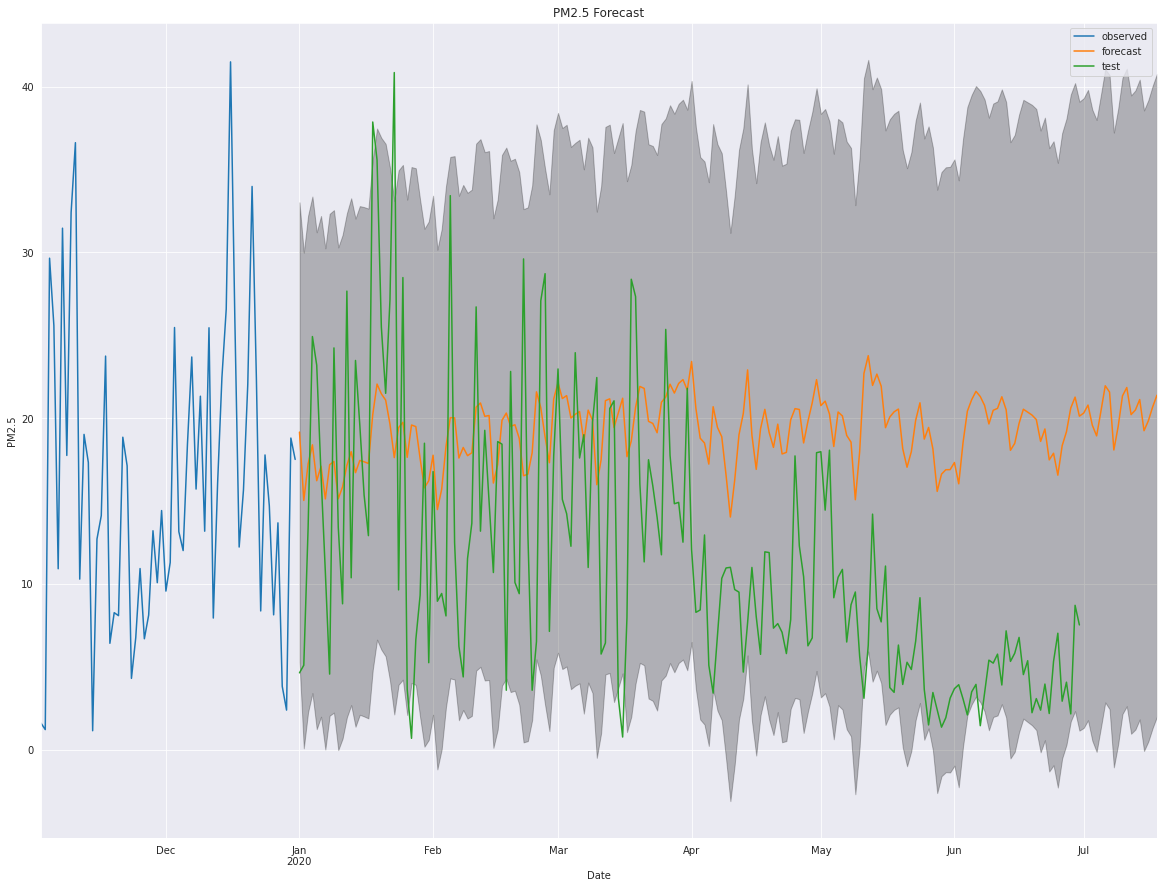

MAPE: 0.5220549846515264
 RMSE: 11.274542079826778


In [99]:
forecast_results(model = model_SARIMAX,
                 steps = 200,
                 days_before = 60,
                 exog = True,
                 exog_values = exog.air_temperature)

### SARIMAX-model with all Exogenous data

In [95]:
endog_features = ['air_temperature', 'wind_direction', 'wind_speed', 'msl_pressure', 'rltv_hum', 'stn_pres']

model_SARIMAX_ENDOG = sm.tsa.statespace.SARIMAX(train.y,
                                                order=(5,1,3),
                                                trend='c',
                                                seasonal_order=(5,1,3,12),
                                                enforce_stationarity=False, 
                                                enforce_invertibility=False,
                                                exog=train[endog_features]
                                               ).fit()
model_SARIMAX_ENDOG.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12401D+00    |proj g|=  1.79289D-01


 This problem is unconstrained.



At iterate    5    f=  3.10791D+00    |proj g|=  4.19056D-02

At iterate   10    f=  3.08741D+00    |proj g|=  1.18875D-01

At iterate   15    f=  3.06181D+00    |proj g|=  1.29971D-01

At iterate   20    f=  3.03660D+00    |proj g|=  2.94327D-01

At iterate   25    f=  3.02084D+00    |proj g|=  1.95115D-01

At iterate   30    f=  3.01659D+00    |proj g|=  8.79114D-02

At iterate   35    f=  3.01577D+00    |proj g|=  1.10736D-02

At iterate   40    f=  3.01487D+00    |proj g|=  1.49388D-01

At iterate   45    f=  3.01467D+00    |proj g|=  4.13575D-02

At iterate   50    f=  3.01460D+00    |proj g|=  8.66598D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  730
Model:             SARIMAX(5, 1, 3)x(5, 1, 3, 12)   Log Likelihood               -2200.657
Date:                            Sun, 15 May 2022   AIC                           4449.314
Time:                                    18:01:59   BIC                           4556.835
Sample:                                01-01-2018   HQIC                          4491.013
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0054      0.005      0.992      0.321      -0.005       0.016
air_temperature    -1.6301      1.287     -1.267      0.205      -4.152       0.891
wind_direction      0.0069      0.005      1.361      0.174      -0.003       0.017
wind_speed         -0.3695      0.092     -4.029      0.000      -0.549      -0.190
msl_pressure      -25.0529     34.287     -0.731      0.465     -92.255      42.149
rltv_hum           -0.0201      0.042     -0.474      0.635      -0.103       0.063
stn_pres           25.2322     34.651      0.728      0.467     -42.684      93.148
ar.L1              -0.4460      0.348     -1.283      0.200      -1.127       0.235
ar.L2              -0.0526      0.194     -0.271      0.786      -0.433       0.328
ar.L3               0.0182      0.091      0.200      0.842      -0.161       0.197
ar.L4              -0.0964      0.062     -1.554      0.120      -0.218       0.025
ar.L5               0.0881      0.049      1.800      0.072      -0.008       0.184
ma.L1              -0.1013      0.352     -0.288      0.774      -0.792       0.589
ma.L2              -0.5241      0.150     -3.502      0.000      -0.817      -0.231
ma.L3              -0.2804      0.286     -0.979      0.327      -0.842       0.281
ar.S.L12           -0.9430      0.201     -4.702      0.000      -1.336      -0.550
ar.S.L24           -0.4095      0.215     -1.908      0.056      -0.830       0.011
ar.S.L36           -0.0086      0.058     -0.150      0.881      -0.121       0.104
ar.S.L48           -0.0525      0.043     -1.218      0.223      -0.137       0.032
ar.S.L60            0.0043      0.020      0.214      0.831      -0.035       0.044
ma.S.L12           -0.0189      0.289     -0.065      0.948      -0.586       0.548
ma.S.L24           -0.5714      0.255     -2.243      0.025      -1.071      -0.072
ma.S.L36           -0.4007      0.228     -1.756      0.079      -0.848       0.047
sigma2             47.6626      9.766      4.881      0.000      28.523      66.803
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1460.25
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             1.26
Prob(H) (two-sided):                  0.17   Kurtosis:                         9.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

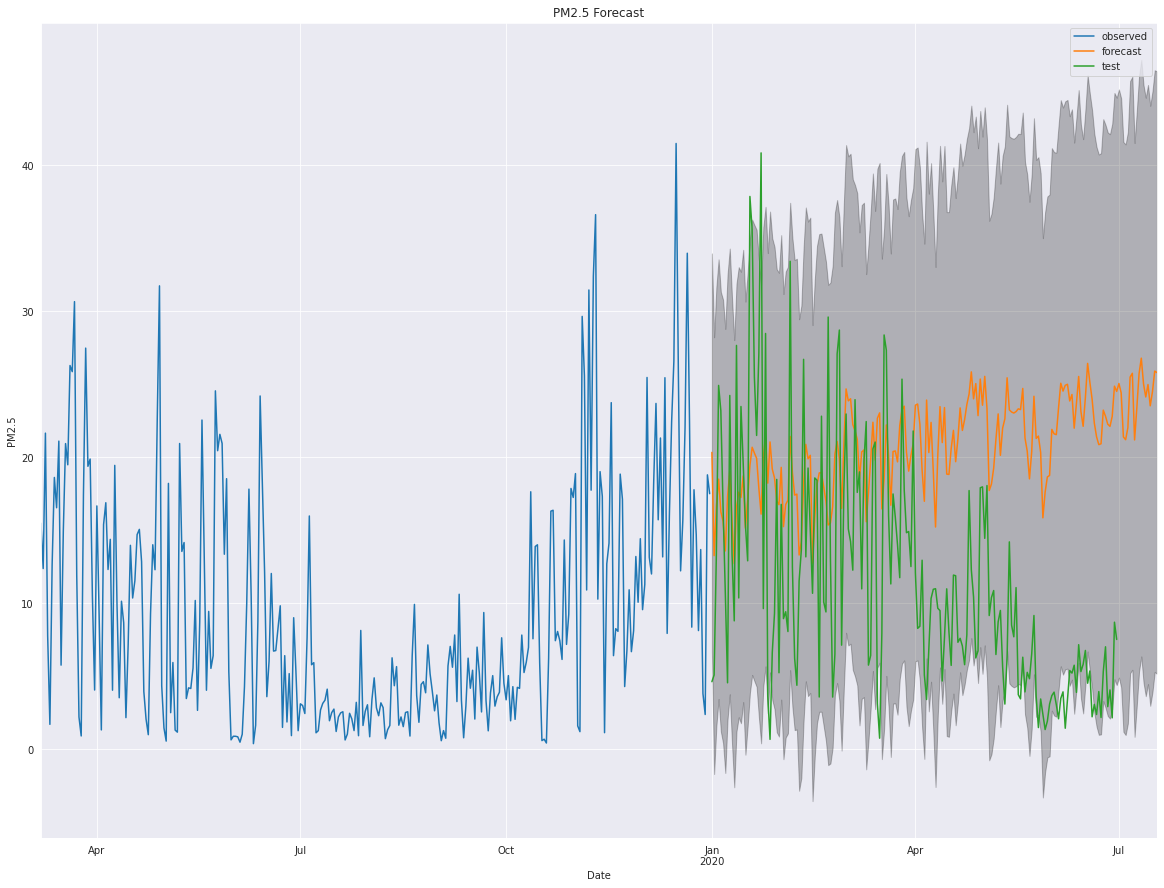

MAPE: 0.539291673338521
 RMSE: 12.929223957718317


In [96]:
forecast_results(model = model_SARIMAX_ENDOG,
                 steps = 200, 
                 days_before = 300, 
                 exog = True, 
                 exog_values = exog[endog_features]
                )

### SARIMAX-model with wind speed as Exogenous data

In [93]:
endog_features = ['wind_speed']

model_SARIMAX_ENDOG_WIND = sm.tsa.statespace.SARIMAX(train.y,order=(3,1,1),trend='c',seasonal_order=(3,1,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[endog_features]).fit()
model_SARIMAX_ENDOG_WIND.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35680D+00    |proj g|=  4.33631D-02


 This problem is unconstrained.


  ys=-1.843E-01  -gs= 4.699E-02 BFGS update SKIPPED

At iterate    5    f=  3.32146D+00    |proj g|=  1.72956D-01

At iterate   10    f=  3.26686D+00    |proj g|=  1.09630D-01

At iterate   15    f=  3.22361D+00    |proj g|=  3.40721D-01

At iterate   20    f=  3.20658D+00    |proj g|=  2.32721D-01

At iterate   25    f=  3.20173D+00    |proj g|=  5.03537D-01

At iterate   30    f=  3.19839D+00    |proj g|=  1.76036D-01

At iterate   35    f=  3.19500D+00    |proj g|=  1.47499D-01

At iterate   40    f=  3.18891D+00    |proj g|=  2.58257D-01

At iterate   45    f=  3.18764D+00    |proj g|=  5.48246D-01

At iterate   50    f=  3.18304D+00    |proj g|=  4.76238D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  730
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -2323.619
Date:                            Sun, 15 May 2022   AIC                           4669.238
Time:                                    18:00:30   BIC                           4718.949
Sample:                                01-01-2018   HQIC                          4688.483
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.133      0.257      -0.002       0.007
wind_speed    -0.4495      0.083     -5.440      0.000      -0.611      -0.288
ar.L1          0.3983      0.046      8.729      0.000       0.309       0.488
ar.L2         -0.0455      0.034     -1.328      0.184      -0.113       0.022
ar.L3         -0.0408      0.037     -1.095      0.274      -0.114       0.032
ma.L1         -0.9036      0.025    -36.731      0.000      -0.952      -0.855
ar.S.L12       0.0069      0.034      0.206      0.837      -0.059       0.073
ar.S.L24      -0.0281      0.040     -0.695      0.487      -0.107       0.051
ar.S.L36      -0.0031      0.008     -0.396      0.692      -0.019       0.012
ma.S.L12      -0.9991      0.862     -1.159      0.247      -2.689       0.691
sigma2        56.3730     47.773      1.180      0.238     -37.261     150.007
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):              1194.34
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             1.09
Prob(H) (two-sided):                  0.35   Kurtosis:                         9.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

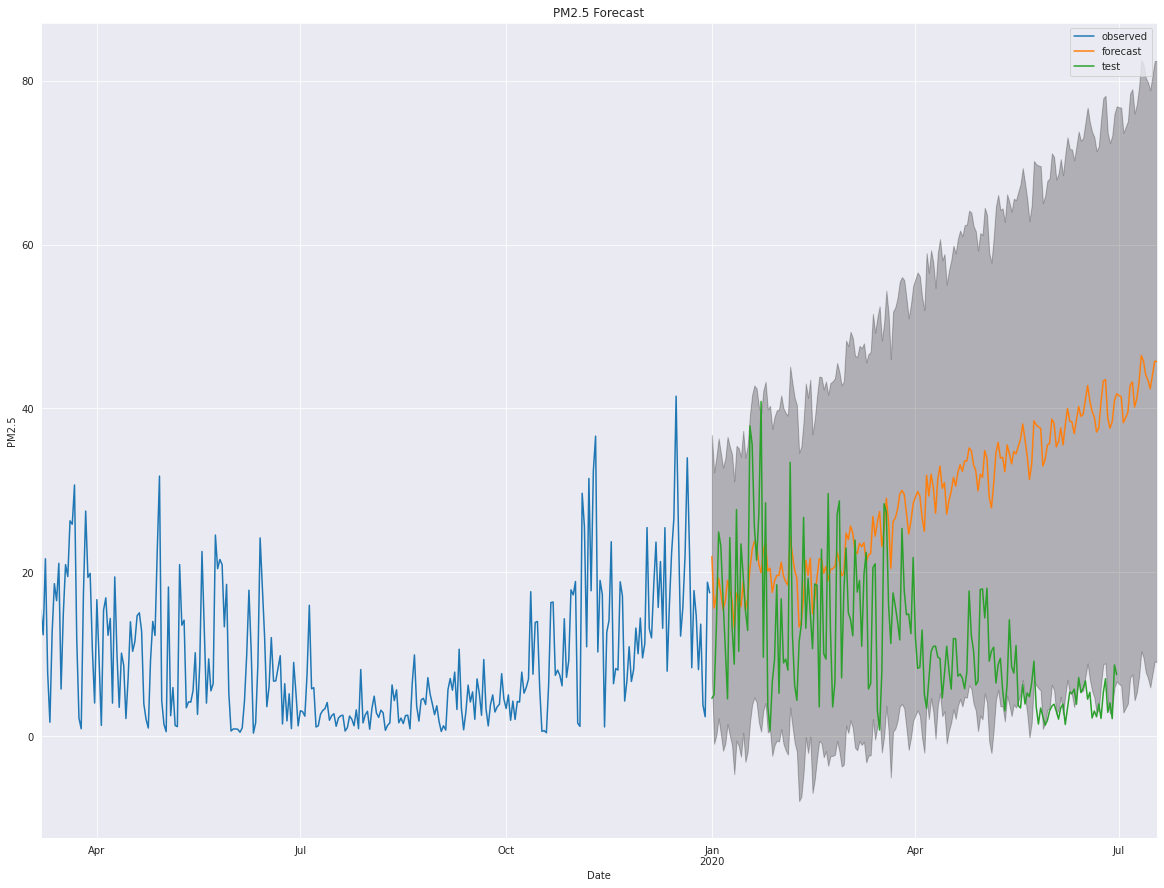

MAPE: 0.5998176589379977
 RMSE: 21.57988231344401


In [94]:

forecast_results(model = model_SARIMAX_ENDOG_WIND,
                 steps = 200, 
                 days_before = 300, 
                 exog = True, 
                 exog_values = exog[endog_features]
                )


### SARIMAX-model with wind speed and air temp as Exogenous data

In [91]:
endog_features = ['wind_speed', 'air_temperature']

model_SARIMAX_ENDOG_WIND_AIR = sm.tsa.statespace.SARIMAX(train.y,order=(3,1,1),trend='c',seasonal_order=(3,1,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[endog_features]).fit()
model_SARIMAX_ENDOG_WIND_AIR.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35258D+00    |proj g|=  4.52666D-02


 This problem is unconstrained.



At iterate    5    f=  3.29825D+00    |proj g|=  1.29208D-01

At iterate   10    f=  3.24879D+00    |proj g|=  1.05403D-01

At iterate   15    f=  3.20941D+00    |proj g|=  7.73411D-01

At iterate   20    f=  3.20140D+00    |proj g|=  6.03458D-02

At iterate   25    f=  3.18885D+00    |proj g|=  5.54188D-01

At iterate   30    f=  3.18726D+00    |proj g|=  1.72079D-01

At iterate   35    f=  3.18547D+00    |proj g|=  1.67357D-01

At iterate   40    f=  3.17100D+00    |proj g|=  2.09634D+00

At iterate   45    f=  3.16816D+00    |proj g|=  6.08639D-01

At iterate   50    f=  3.16565D+00    |proj g|=  8.36974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  730
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -2310.925
Date:                            Sun, 15 May 2022   AIC                           4645.850
Time:                                    17:59:21   BIC                           4700.080
Sample:                                01-01-2018   HQIC                          4666.844
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0011      0.001      1.260      0.208      -0.001       0.003
wind_speed         -0.3560      0.077     -4.628      0.000      -0.507      -0.205
air_temperature    -0.8842      0.150     -5.883      0.000      -1.179      -0.590
ar.L1               0.3423      0.039      8.699      0.000       0.265       0.419
ar.L2              -0.0213      0.032     -0.663      0.507      -0.084       0.042
ar.L3              -0.0464      0.033     -1.387      0.166      -0.112       0.019
ma.L1              -0.9627      0.012    -78.143      0.000      -0.987      -0.939
ar.S.L12         8.068e-05      0.031      0.003      0.998      -0.060       0.060
ar.S.L24           -0.0504      0.037     -1.377      0.169      -0.122       0.021
ar.S.L36            0.0032      0.005      0.583      0.560      -0.007       0.014
ma.S.L12           -0.9963      0.197     -5.069      0.000      -1.382      -0.611
sigma2             51.0969      9.419      5.425      0.000      32.636      69.557
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):              1311.42
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             1.23
Prob(H) (two-sided):                  0.15   Kurtosis:                         9.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

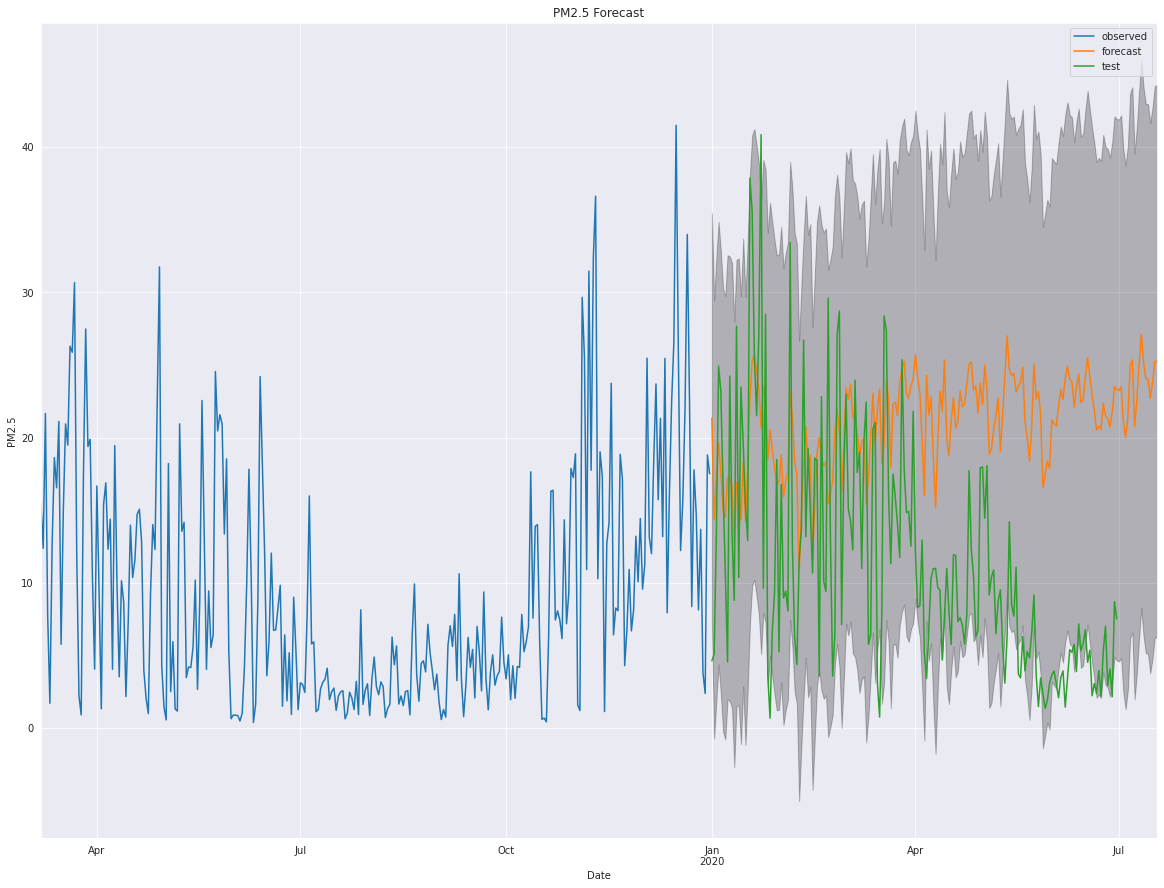

MAPE: 0.5348515521013804
 RMSE: 12.85207953166811


In [92]:

forecast_results(model = model_SARIMAX_ENDOG_WIND_AIR,
                 steps = 200, 
                 days_before = 300, 
                 exog = True, 
                 exog_values = exog[endog_features]
                )


In [14]:
tr_start, tr_end = '2018-01-01', '2019-12-31'
te_start, te_end = '2020-01-01', '2020-06-30'

train = df_sd[tr_start : tr_end]
test = df_sd[te_start : te_end]
exog = df_sd[te_start : ]

all_pm25 = df_sd[tr_start : te_end]

In [15]:
endog_features = ['wind_speed', 'air_temperature']

model_SARIMAX_ENDOG_WIND_AIR = sm.tsa.statespace.SARIMAX(train.y,order=(3,1,1),trend='c',seasonal_order=(3,1,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[endog_features]).fit()
model_SARIMAX_ENDOG_WIND_AIR.summary()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35258D+00    |proj g|=  4.52666D-02

At iterate    5    f=  3.29825D+00    |proj g|=  1.29208D-01

At iterate   10    f=  3.24879D+00    |proj g|=  1.05403D-01

At iterate   15    f=  3.20941D+00    |proj g|=  7.73411D-01

At iterate   20    f=  3.20140D+00    |proj g|=  6.03458D-02

At iterate   25    f=  3.18885D+00    |proj g|=  5.54188D-01

At iterate   30    f=  3.18726D+00    |proj g|=  1.72079D-01

At iterate   35    f=  3.18547D+00    |proj g|=  1.67357D-01

At iterate   40    f=  3.17100D+00    |proj g|=  2.09634D+00

At iterate   45    f=  3.16816D+00    |proj g|=  6.08639D-01

At iterate   50    f=  3.16565D+00    |proj g|=  8.36974D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  730
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -2310.925
Date:                            Sun, 15 May 2022   AIC                           4645.850
Time:                                    17:27:25   BIC                           4700.080
Sample:                                01-01-2018   HQIC                          4666.844
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0011      0.001      1.260      0.208      -0.001       0.003
wind_speed         -0.3560      0.077     -4.628      0.000      -0.507      -0.205
air_temperature    -0.8842      0.150     -5.883      0.000      -1.179      -0.590
ar.L1               0.3423      0.039      8.699      0.000       0.265       0.419
ar.L2              -0.0213      0.032     -0.663      0.507      -0.084       0.042
ar.L3              -0.0464      0.033     -1.387      0.166      -0.112       0.019
ma.L1              -0.9627      0.012    -78.143      0.000      -0.987      -0.939
ar.S.L12         8.068e-05      0.031      0.003      0.998      -0.060       0.060
ar.S.L24           -0.0504      0.037     -1.377      0.169      -0.122       0.021
ar.S.L36            0.0032      0.005      0.583      0.560      -0.007       0.014
ma.S.L12           -0.9963      0.197     -5.069      0.000      -1.382      -0.611
sigma2             51.0969      9.419      5.425      0.000      32.636      69.557
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):              1311.42
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             1.23
Prob(H) (two-sided):                  0.15   Kurtosis:                         9.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

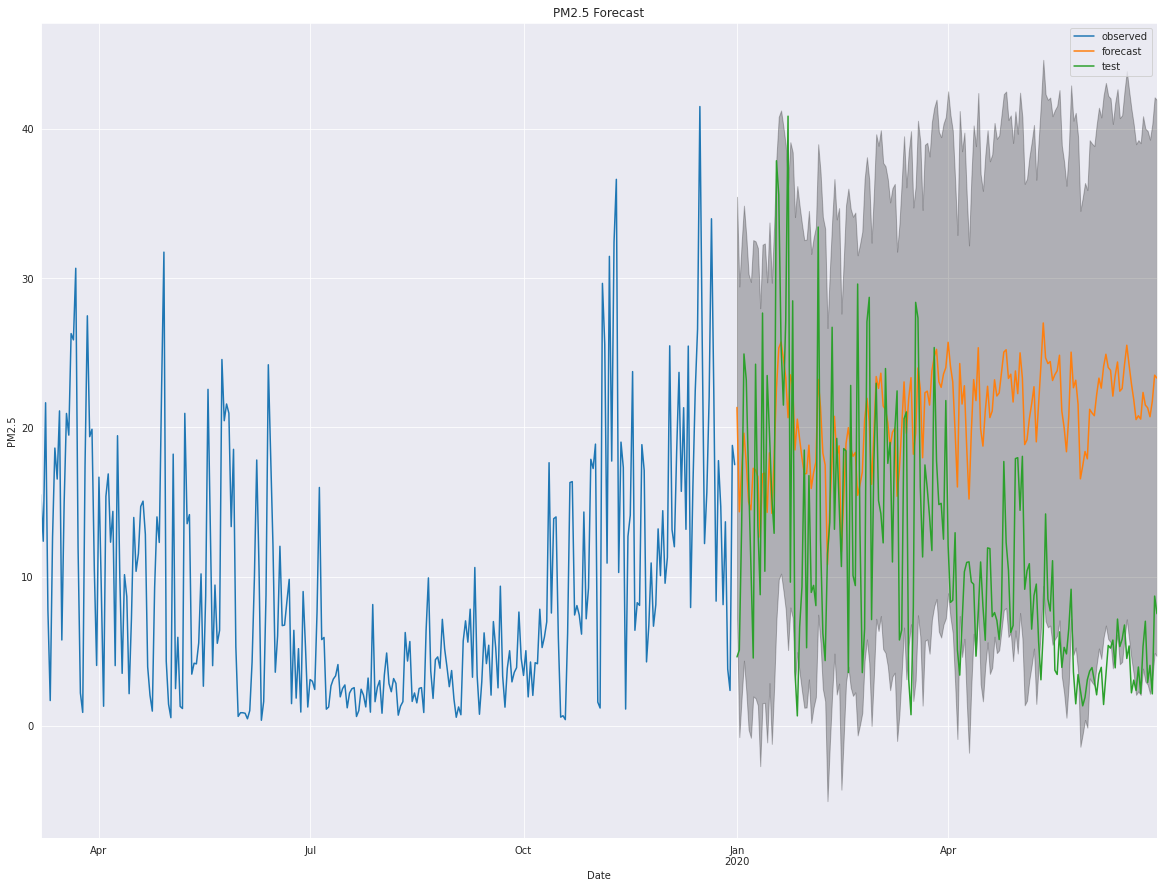

MAPE: 0.5348515521013804
 RMSE: 12.85207953166811


In [74]:

forecast_results(model = model_SARIMAX_ENDOG_WIND_AIR,
                 steps = len(test), 
                 days_before = 300, 
                 exog = True, 
                 exog_values = exog[endog_features]
                )

## Trying with rolling values

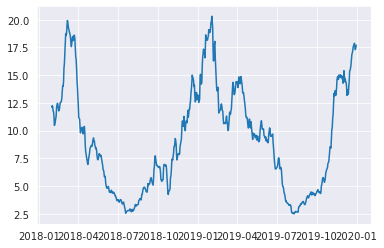

In [103]:
plt.plot(train.y.rolling(30, axis = 0).mean().dropna())

#train['2018-01-07':'2019-12-31'][['wind_speed', 'air_temperature']]

In [108]:
endog_features = ['wind_speed', 'air_temperature']
df_rolling = train.y.rolling(30, axis = 0).mean().dropna()

model_ARIMA1_EXOG = ARIMA(df_rolling, 
                          exog = train[min(df_rolling.index) : max(df_rolling.index)][endog_features], 
                          order = (5, 1,3)
                         ).fit()
model_ARIMA1_EXOG.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  701
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -228.613
Date:                Sun, 15 May 2022   AIC                            479.226
Time:                        18:10:06   BIC                            529.288
Sample:                    01-30-2018   HQIC                           498.578
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
wind_speed         -0.0085      0.003     -3.166      0.002      -0.014      -0.003
air_temperature     0.0081      0.008      1.020      0.308      -0.007       0.024
ar.L1              -0.0289      0.186     -0.155      0.876      -0.393       0.336
ar.L2               0.3565      0.155      2.305      0.021       0.053       0.660
ar.L3               0.0305      0.133      0.230      0.818      -0.229       0.290
ar.L4              -0.0466      0.074     -0.627      0.531      -0.192       0.099
ar.L5               0.1851      0.030      6.251      0.000       0.127       0.243
ma.L1               0.4932      0.191      2.586      0.010       0.119       0.867
ma.L2              -0.2642      0.171     -1.542      0.123      -0.600       0.072
ma.L3              -0.1136      0.173     -0.657      0.511      -0.453       0.225
sigma2              0.1123      0.004     30.521      0.000       0.105       0.120
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               631.41
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.12
Prob(H) (two-sided):                  0.99   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

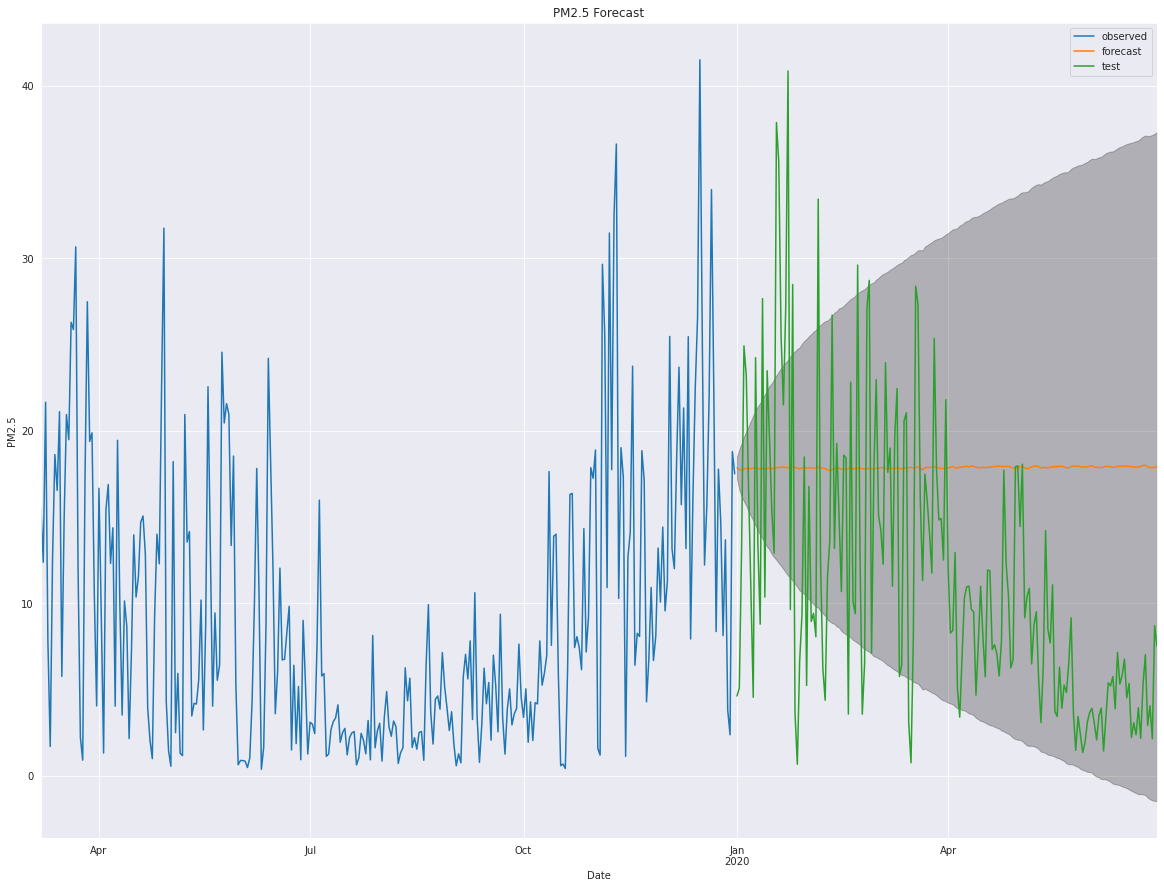

MAPE: 0.5135156909228117
 RMSE: 10.362552542322364


In [110]:

forecast_results(model = model_ARIMA1_EXOG,
                 steps = len(test), 
                 days_before = 300, 
                 exog = True, 
                 exog_values = exog[endog_features]
                )

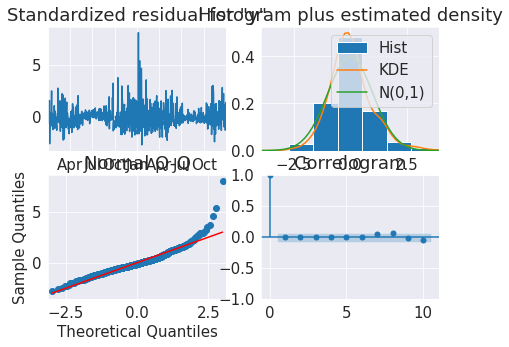

In [202]:
model_ARIMA1_EXOG.plot_diagnostics(figsize=(7,5))
plt.show()